## Import Modules/Libraries

## Setup Paths and other parameters

This is the main cell to change the parameters and imaging paths around.

In [1]:
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession
# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

In [2]:
def All5Fold(LayerName1 = 'Red_OutputFinal' , LayerName2 = 'Green_OutputFinal', LayerName3 = 'Blue_OutputFinal', fold_number = 1):
    #Cell -1

    import tensorflow
    import tensorflow as tf
    from tensorflow.keras.applications import vgg16, efficientnet, EfficientNetV2S
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Input, Convolution2D, MaxPool2D, Dense, Flatten, Dropout
    from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
    from tensorflow.keras.utils import plot_model
    from tensorflow.keras import metrics
    from tensorflow.keras.regularizers import l1
    from keras.callbacks import ReduceLROnPlateau
    import cv2
    from PIL import Image
    #
    import matplotlib.pyplot as plt
    from sklearn.model_selection import train_test_split
    from sklearn.utils.class_weight import compute_class_weight
    #
    from pathlib import Path
    import pandas as pd
    import numpy as np
    #
    from datetime import datetime
    import os
    import platform
    #
    from tensorflow.python.client import device_lib
    print(device_lib.list_local_devices())
    print('Tensorflow Version: ',tensorflow.__version__)
    print('tf.keras Version  : ',tensorflow.keras.__version__)
    
    #Cell 0
    # %cd C:\Users\Developer\MyProjects\ROP_Plus\ROP_Plus_NoPlus



    def change_directory(path):
        try:
            # Change to the specified directory
            os.chdir(path)
            print(f"Changed directory to: {os.getcwd()}")
        except FileNotFoundError:
            print(f"The directory {path} does not exist.")
        except Exception as e:
            print(f"An error occurred: {e}")

    # Example usage
    if __name__ == "__main__":
        # Define the path for both Windows and Linux
        if platform.system() == "Windows":
            path = r"C:\Users\Developer\MyProjects\ROP_Pre-Plus_LightSpec\ROP_LightSpec_Pre-Plus"  # Raw string for Windows
        else:
            path = "/home/developer/Documents/MyProjects/ROP_Pre-Plus_LightSpec/ROP_LightSpec_Pre-Plus"  # Linux path

        change_directory(path)


    #Cell 1

    ClassNameVar = 'Golden Reading Plus'
    #Cell 1
#     fold_num = 5
#     LayerName = 'Red'
    X_col = 'posterior_id'
    epochs = 90 
    fold_num = fold_number
    #
    # Image size
    img_width, img_height, img_depth =  640, 480, 3


    
    dataPathFirstSeg = '../Dataset/All_Data/'
    csvFilesPathFirstSeg = '../Dataset'
    #
    # Data organization - Training Data
    data_dir1 = Path(dataPathFirstSeg + LayerName1 +'/')
    csv_dir = Path(csvFilesPathFirstSeg)
    csv_name = 'train' + str(fold_num) + '.csv'
    csv_path = csv_dir / csv_name
    df_train1 = pd.read_csv(csv_path)

    df_train1 = df_train1.sample(frac = 1, random_state = fold_num)
    
   

    data_dir2 = Path(dataPathFirstSeg + LayerName2 +'/')
    csv_dir = Path(csvFilesPathFirstSeg)
    csv_name = 'train' + str(fold_num) + '.csv'
    csv_path = csv_dir / csv_name
    df_train2 = pd.read_csv(csv_path)

    df_train2 = df_train2.sample(frac = 1, random_state = fold_num)


    data_dir3 = Path(dataPathFirstSeg + LayerName3 +'/')
    csv_dir = Path(csvFilesPathFirstSeg)
    csv_name = 'train' + str(fold_num) + '.csv'
    csv_path = csv_dir / csv_name
    df_train3 = pd.read_csv(csv_path)

    df_train3 = df_train3.sample(frac = 1, random_state = fold_num)



    #
    # Data organization - Validation and Testing Data
    test_data_dir1 = Path(dataPathFirstSeg + LayerName1 + '/')
    csv_dir = Path(csvFilesPathFirstSeg)
    csv_name = 'valid' + str(fold_num) + '.csv'
    csv_path = csv_dir / csv_name
    df_test1 = pd.read_csv(csv_path)

    test_data_dir2 = Path(dataPathFirstSeg + LayerName2 + '/')
    csv_dir = Path(csvFilesPathFirstSeg)
    csv_name = 'valid' + str(fold_num) + '.csv'
    csv_path = csv_dir / csv_name
    df_test2 = pd.read_csv(csv_path)


    test_data_dir3 = Path(dataPathFirstSeg + LayerName3 + '/')
    csv_dir = Path(csvFilesPathFirstSeg)
    csv_name = 'valid' + str(fold_num) + '.csv'
    csv_path = csv_dir / csv_name
    df_test3 = pd.read_csv(csv_path)

    class_names = ['Normal','Pre-Plus','Plus']  # Used for the confusion matrix at the end

    # df_test.to_csv('AAAAAAAAAAAAAAAA.csv', index = False)

    # Training parameters
#     epochs = 300                     # For fitting the model
    freq = epochs // 2              # For saving the model

    batch_size = 2 #len(df_train1)               # For fitting the model/ data augmentation parameters
    batch_size_valid = 2            # For fitting the model/ data augmentation parameters

    # if fold_num == 3 :
    #   batch_size = 48                 # For fitting the model/ data augmentation parameters
    #   batch_size_valid = 12            # For fitting the model/ data augmentation parameters

    num_classes = len(class_names)                  # For the model architecture
    train_valid_split = 0.2        # For data-augmentation parameters
    #
    # Learning rate
    learning_rate = 0.00001         # For fitting the model
    #
    # This is the different layers and their corresponding information
    # Layer Number | Name of Layer | Output size | Number of parameters
    # -8 block4_conv1 (Conv2D)        (None, 38, 38, 512)       1180160
    # _________________________________________________________________
    # -7 block4_conv2 (Conv2D)        (None, 38, 38, 512)       2359808
    # _________________________________________________________________
    # -6 block4_conv3 (Conv2D)        (None, 38, 38, 512)       2359808
    # _________________________________________________________________
    # -5 block4_pool (MaxPooling2D)   (None, 19, 19, 512)       0
    # _________________________________________________________________
    # -4 block5_conv1 (Conv2D)        (None, 19, 19, 512)       2359808
    # _________________________________________________________________
    # -3 block5_conv2 (Conv2D)        (None, 19, 19, 512)       2359808
    # _________________________________________________________________
    # -2 block5_conv3 (Conv2D)        (None, 19, 19, 512)       2359808
    # _________________________________________________________________
    # -1 block5_pool (MaxPooling2D)   (None, 9, 9, 512)         0
    #
    # Transfer learning layers
    train_false_layer = -1 # Based on the Layer Number.
    #
    # I automated this part for binary or non-binary classification.
    if num_classes < 2:
        act_type = 'sigmoid'
        class_mode = 'binary'
        loss_fun = 'binary_crossentropy'
    else:
        act_type = 'softmax'
        class_mode = 'categorical'
        loss_fun = 'categorical_crossentropy'
    #
    print('Type of classification: ', class_mode)
    print('Loss function: ', loss_fun)
    print('Activation function: ', act_type)
    len(df_train1)

    #Cell 2


    data_gen_args = dict(
    rescale = 1./255,
    brightness_range = [0.5,1.5],
    horizontal_flip = True,
    vertical_flip = True,
    rotation_range = 45.,
    zoom_range = 0.4,
    height_shift_range = 0.1,
    width_shift_range = 0.1,
    shear_range = 0.3,

    # featurewise_center = True,
    # featurewise_std_normalization = True,
    # samplewise_std_normalization= True,
    # samplewise_center=True,
    fill_mode = 'reflect'
    # validation_split=train_valid_split
    )


    print("A")

    #
    datagen = ImageDataGenerator(
        **data_gen_args)
    #
    # Train data generator
    train_generator1 = datagen.flow_from_dataframe(
        dataframe = df_train1,
        directory = data_dir1,
        x_col = X_col, #LayerName1,
        y_col = ClassNameVar,
        seed= 123,
        target_size = (img_height, img_width),
        class_mode = class_mode,
        color_mode = 'rgb',
        batch_size = batch_size,
        shuffle = True)
    
    
    #
    print("B")
    # Train data generator
    train_generator2 = datagen.flow_from_dataframe(
        dataframe = df_train2,
        directory = data_dir2,
        x_col = X_col, #LayerName1,
        y_col = ClassNameVar,
        seed= 123,
        target_size = (img_height, img_width),
        class_mode = class_mode,
        color_mode = 'rgb',
        batch_size = batch_size,
        shuffle = True)



    # Train data generator
    train_generator3 = datagen.flow_from_dataframe(
        dataframe = df_train3,
        directory = data_dir3,
        x_col = X_col, #LayerName1,
        y_col = ClassNameVar,
        seed= 123,
        target_size = (img_height, img_width),
        class_mode = class_mode,
        color_mode = 'rgb',
        batch_size = batch_size,
        shuffle = True)



    # Validation data generator
    valid_data_gen_args = dict(
        rescale = 1./255,
    )

    valid_datagen = ImageDataGenerator(
        **valid_data_gen_args)

    


    valid_generator1 = valid_datagen.flow_from_dataframe(
        dataframe = df_test1,
        directory = test_data_dir1,
        x_col = X_col, #LayerName1,
        y_col = ClassNameVar,
        seed=123,
        # subset = 'validation',
        target_size = (img_height, img_width),
        class_mode = class_mode,
        color_mode = 'rgb',
        batch_size = batch_size_valid,
        shuffle = True)
    #

    valid_generator2 = valid_datagen.flow_from_dataframe(
        dataframe = df_test2,
        directory = test_data_dir2,
        x_col = X_col, #LayerName1,
        y_col = ClassNameVar,
        seed=123,
        # subset = 'validation',
        target_size = (img_height, img_width),
        class_mode = class_mode,
        color_mode = 'rgb',
        batch_size = batch_size_valid,
        shuffle = True)


    valid_generator3 = valid_datagen.flow_from_dataframe(
        dataframe = df_test3,
        directory = test_data_dir3,
        x_col = X_col, #LayerName1,
        y_col = ClassNameVar,
        seed=123,
        # subset = 'validation',
        target_size = (img_height, img_width),
        class_mode = class_mode,
        color_mode = 'rgb',
        batch_size = batch_size_valid,
        shuffle = True)



    def combine_generator(gen1, gen2, gen3):
        while True:
            x_gen1,y_gen1 = next(gen1)
            x_gen2,y_gen2 = next(gen2)
            x_gen3,y_gen3 = next(gen3)
            x_gen_merge=tf.concat([x_gen1, x_gen2, x_gen3], -1)
            yield(x_gen_merge, y_gen1)

    combine_train_generator = combine_generator(train_generator1, train_generator2,train_generator3)
    combine_valid_generator = combine_generator(valid_generator1, valid_generator2,valid_generator3)

    X_combine_train, y_combine_train = next(combine_train_generator)
    X_combine_valid, y_combine_valid = next(combine_valid_generator)




    # Preview the augmented data
    X_preview = X_combine_train[:,:,:,:3]
    y_preview = y_combine_train
    
    print(X_preview.shape)
    #
    for k in range(1,2):
        sample_img = X_preview[k,:,:,:]
        plt.subplot(2, 3, k)
        plt.imshow(sample_img)
    plt.suptitle('Sample Data Augmentation', fontsize = 16)
    plt.show()
    #
    print('y Labels: ', y_preview[1:5])
    print('sample img, max value: ',np.max(sample_img))
    print('sample img, min value: ',np.min(sample_img))


    # Preview the augmented data
    X_preview = X_combine_train[:,:,:,3:6]
    y_preview = y_combine_train
    #
    for k in range(1,2):
        sample_img = X_preview[k,:,:,:]
        plt.subplot(2, 3, k)
        plt.imshow(sample_img)
    plt.suptitle('Sample Data Augmentation', fontsize = 16)
    plt.show()
    #
    print('y Labels: ', y_preview[1:5])
    print('sample img, max value: ',np.max(sample_img))
    print('sample img, min value: ',np.min(sample_img))


    # Preview the augmented data
    X_preview = X_combine_train[:,:,:,6:]
    y_preview = y_combine_train
    #
    for k in range(1,2):
        sample_img = X_preview[k,:,:,:]
        plt.subplot(2, 3, k)
        plt.imshow(sample_img)
    plt.suptitle('Sample Data Augmentation', fontsize = 16)
    plt.show()
    #
    print('y Labels: ', y_preview[1:5])
    print('sample img, max value: ',np.max(sample_img))
    print('sample img, min value: ',np.min(sample_img))

    #Cell 3

    # Preview the augmented data

    #Cell 4

    # Preview the augmented data
    X_preview_val = X_combine_valid[:,:,:,:3]
    y_preview_val = y_combine_valid


    for k in range(1,2):
        sample_img = X_preview_val[k,:,:,:]
        plt.subplot(2, 3, k)
        plt.imshow(sample_img)
    plt.suptitle('Sample Data Augmentation', fontsize = 16)
    plt.show()
    #
    print('y Labels: ', y_preview_val[1:5])
    print('sample img, max value: ',np.max(sample_img))
    print('sample img, min value: ',np.min(sample_img))



    # Preview the augmented data
    X_preview_val = X_combine_valid[:,:,:,3:6]
    y_preview_val = y_combine_valid


    for k in range(1,2):
        sample_img = X_preview_val[k,:,:,:]
        plt.subplot(2, 3, k)
        plt.imshow(sample_img)
    plt.suptitle('Sample Data Augmentation', fontsize = 16)
    plt.show()
    #
    print('y Labels: ', y_preview_val[1:5])
    print('sample img, max value: ',np.max(sample_img))
    print('sample img, min value: ',np.min(sample_img))



    # Preview the augmented data
    X_preview_val = X_combine_valid[:,:,:,6:]
    y_preview_val = y_combine_valid


    for k in range(1,2):
        sample_img = X_preview_val[k,:,:,:]
        plt.subplot(2, 3, k)
        plt.imshow(sample_img)
    plt.suptitle('Sample Data Augmentation', fontsize = 16)
    plt.show()
    #
    print('y Labels: ', y_preview_val[1:5])
    print('sample img, max value: ',np.max(sample_img))
    print('sample img, min value: ',np.min(sample_img))


    #Cell 5
    #########################Distribute####################################
#     strategy = tf.distribute.MirroredStrategy()
#     print("Number of devices: {}".format(strategy.num_replicas_in_sync))
    
#     with strategy.scope():
    from keras.layers import Lambda
    from tensorflow.keras.layers import Concatenate

    def filterChannel(inputDataFromPrevLayer, maskIn = [1,1,1]):
        branch_outputs = []
        mask = maskIn
        for i in range(img_depth):
            if i == 0:
                out = inputDataFromPrevLayer[:,:,:,0]*mask[i]
            elif i == 1:
                out = inputDataFromPrevLayer[:,:,:,1]*mask[i]
            elif i == 2:
                out = inputDataFromPrevLayer[:,:,:,2]*mask[i]

            # out = inputDataFromPrevLayer[:,:,:,i]*mask[i]
            branch_outputs.append(tf.expand_dims(out, axis=-1))

        return Concatenate(axis = -1)(branch_outputs)

    import inspect
    filterChannelFuncRepr, filterChannelLine_no = inspect.getsourcelines(filterChannel)



    def creatModel(modelNumber, model_image_input):
        base_model = EfficientNetV2S(
            input_tensor = model_image_input,
            include_top = False,
            weights = 'imagenet'
        )
        #

#             for layer in base_model.layers:
#               layer.trainable = False

        for layer in base_model.layers:
          layer._name = layer._name + str(modelNumber)

        base_output = base_model.layers[-1].output

        return base_output



    from keras.layers import Lambda
    from tensorflow.keras.layers import Concatenate

    def layerSlicer(inputDataFromPrevLayer):
        inputL1 = inputDataFromPrevLayer[:,:,:,:3]
        # tf.shape(inputL1)
        inputL2 = inputDataFromPrevLayer[:,:,:,3:6]
        inputL3 = inputDataFromPrevLayer[:,:,:,6:]
        return inputL1,inputL2,inputL3






    #Cell 6


    # Build Model
    from tensorflow import keras
    from tensorflow.keras import layers
    totalLayerNumber = 3
#     inputAll= Input(shape = (img_width, img_height, totalLayerNumber*img_depth))
    inputAll = Input(shape = (img_height, img_width, totalLayerNumber*img_depth))
    xl1, xl2, xl3 = Lambda(layerSlicer)(inputAll)

    baseModeInput1 = Lambda(filterChannel)(xl1, [1,1,1])
    baseModeInput2 = Lambda(filterChannel)(xl2, [1,1,1])
    baseModeInput3 = Lambda(filterChannel)(xl3, [1,1,1])

    base_out1 = creatModel(1,baseModeInput1)
    base_out2 = creatModel(2,baseModeInput2)
    base_out3 = creatModel(3,baseModeInput3)




    #############################

#     flatA1 = Flatten()(base_out1)
    flatA1 = tf.keras.layers.GlobalAveragePooling2D()(base_out1)
    dropOutflatA1 = Dropout(0.1)(flatA1)
    fcA1 = Dense(1000, activation = 'relu')(dropOutflatA1)
#     fcA2 = Dense(4096, activation = 'relu')(fcA1)
    outputA = Dense(num_classes, activation = act_type)(fcA1)


    modelA = Model(xl1, outputA)
#         checkpoint_pathA = Path('Results/fold_num_'+ str(fold_num) +'early_stop_model_Red.hdf5')
#         modelA.load_weights(checkpoint_pathA)

    # for layer in modelA.layers:
    #     layer.trainable = False

    #

#     flatB1 = Flatten()(base_out2)
    flatB1 = tf.keras.layers.GlobalAveragePooling2D()(base_out2)
    dropOutflatB1 = Dropout(0.1)(flatB1)
    fcB1 = Dense(1000, activation = 'relu')(dropOutflatB1)
#     fcB2 = Dense(4096, activation = 'relu')(fcB1)
    outputB = Dense(num_classes, activation = act_type)(fcB1)

    modelB = Model(xl2, outputB)
#         checkpoint_pathB = Path('Results/fold_num_'+ str(fold_num) +'early_stop_model_Green.hdf5')
#         modelB.load_weights(checkpoint_pathB)

    # for layer in modelB.layers[:-1]:
    #     layer.trainable = False
    #
    #
    #

#     flatC1 = Flatten()(base_out3)
    flatC1 = tf.keras.layers.GlobalAveragePooling2D()(base_out3)
    dropOutflatC1 = Dropout(0.1)(flatC1)
    fcC1 = Dense(1000, activation = 'relu')(dropOutflatC1)
#     fcC2 = Dense(4096, activation = 'relu')(fcC1)
    outputC = Dense(num_classes, activation = act_type)(fcC1)

    modelC = Model(xl3, outputC)
#         checkpoint_pathC = Path('Results/fold_num_'+ str(fold_num) +'early_stop_model_Blue.hdf5')
#         modelC.load_weights(checkpoint_pathC)

    # for layer in modelC.layers[:-1]:
    #     layer.trainable = False
    #
    #

    initializerA = modelA.layers[-3].get_weights()
    initializerB = modelB.layers[-3].get_weights()
    initializerC = modelC.layers[-3].get_weights()

    ############################



    print("########################## \n")
    print(tf.shape(modelC.layers[-4].output))
    print("# \n")
    print(tf.shape(modelC.layers[-5].output))
    print("# \n")
    print(tf.shape(modelC.layers[-3].output))

    concatBaseOutput =   Concatenate()([modelA.layers[-5].output,modelB.layers[-5].output,modelC.layers[-5].output])



#         customConv1 = Convolution2D(filters=totalLayerNumber*1280, kernel_size=(3,3), padding="same", activation="relu")(concatBaseOutput)

    # customCMaxpool1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(customConv1)


    # initializer10 = tf.concat([initializerA[0], initializerB[0], initializerC[0]], 0)
    # initializer11 = tf.concat([initializerA[1], initializerB[1], initializerC[1]], 0)


    # print(len(initializerA[0]))
    # print(len(initializerA[1]))


    # print(len(initializer10))
    # print(len(initializer11))

    # initializer2 = modelA.layers[-2].get_weights()
    # initializerOut = modelA.layers[-1].get_weights()

#         flat1 = Flatten()(customConv1)
    flat1 = tf.keras.layers.GlobalAveragePooling2D()(concatBaseOutput)
    dropOutflat = Dropout(0.1)(flat1)
    fc1 = Dense(1000, activation = 'relu')(dropOutflat)
#     # fc1.build(input_shape=[None,41472])
#     # fc1.set_weights([initializer10, initializer11])
#     fc1Out = fc1(dropOutflat)


#     # dropfc1 = Dropout(0.3)(fc1)
#     fc2 = Dense(4096, activation = 'relu')
#     # fc2.build(input_shape=[None,len(initializer2[0])])
#     # fc2.set_weights([initializer2[0], initializer2[1]])
#     fc2Out = fc2(fc1Out)

    output = Dense(num_classes, activation = act_type)(fc1)
#     # output.build(input_shape=[None,len(initializerOut[0])])
#     # output.set_weights([initializerOut[0], initializerOut[1]])
#     outputOut= output(fc1Out)
    #Behro


    model = Model(inputAll, output)


    model.summary()


    #Cell 7

    # Compile the model
    METRICS = [
        metrics.TruePositives(name='tp'),
        # metrics.FalsePositives(name='fp'),
        # metrics.TrueNegatives(name='tn'),
        # metrics.FalseNegatives(name='fn'),
        metrics.CategoricalAccuracy(name='accuracy'),
        # metrics.Precision(name='precision'),
        # metrics.Recall(name='recall'),
        # metrics.AUC(name='auc'),
        # metrics.AUC(name='prc', curve='PR'), # precision-recall curve
    ]

    opt = Adam(learning_rate = learning_rate)
    #
    model.compile(
        loss = loss_fun,
        optimizer = opt,
        # metrics = ['accuracy']
        metrics= METRICS
    )

   ################################Distribute###############################

    #Cell 8

    # Folder setup
    if not os.path.isdir('Results'):
        os.mkdir('Results')

    init_time = datetime.now()
    current_time = init_time.strftime('%Y%m%d_%H%M%S')
    name_dir = 'Results/trained_models_' + current_time + '_fold_num' + str(fold_num) + '_' + str(LayerName1) + str(LayerName2) + str(LayerName3)
    os.mkdir(name_dir)
    #
    # Callbacks1: ModelCheckpointer
    model_file_format = name_dir + '/model_' + str(fold_num) + '_model.{epoch:04d}.hdf5'
    check = ModelCheckpoint(
        model_file_format,
        save_freq = freq, # The 'freq' parameter is defined previously as "epoch // 2", I want to save 2 model weights for comparison.
        verbose = 1,
        save_weights_only=True # We only save the weights, because if we save all the information, its 2.9 GB per file. Too much data.
    )
    
    checkpointer = ModelCheckpoint(
        model_file_format,
        period = 10,
        save_best_only=False,
        save_weights_only=True
    )
    #
    # Callbacks2: EarlyStopping
    early_stop = EarlyStopping(
        monitor='val_accuracy',
        min_delta=0,
        patience=20,
        verbose=0,
        mode='auto',
        restore_best_weights=True
    )
    #
    # Plot model
    figure_name = name_dir + '/model_output.png'
    #
    plot_model(
        model,
        figure_name,
        show_shapes = True
    )
    #
    # Display model
    # model.summary()


    #Cell 9

    class_weights = compute_class_weight(
        class_weight = 'balanced',
        classes = np.unique(train_generator1.classes),
        y = train_generator1.classes
    )
    class_weights = dict(enumerate(class_weights))
    #
    nb_train_samples = len(train_generator1.classes)
    nb_valid_samples = len(valid_generator1.classes)
    #
    steps_per_epoch_param = nb_train_samples // batch_size
    validation_steps_param = nb_valid_samples // batch_size_valid
    #
    print('nb_train_samples: ',nb_train_samples)
    print('nb_valid_samples: ',nb_valid_samples)
    print('steps_per_epoch_param: ',steps_per_epoch_param)
    print('validation_steps_param: ',validation_steps_param)
    print(class_weights)


    #Cell 10


    from keras.callbacks import EarlyStopping
    class MyEarlyStopping(EarlyStopping):
        def __init__(self, *args, **kw):
            super().__init__(*args, **kw)
            self.baseline_attained = False

        def on_epoch_end(self, epoch, logs=None):
            if not self.baseline_attained:
                current = self.get_monitor_value(logs)
                if current is None:
                    return

                if self.monitor_op(current, self.baseline):
                    if self.verbose > 0:
                        print(' Baseline attained.')
                    self.baseline_attained = True
                    print("\nBefore   %f." %self.model.optimizer.learning_rate)
                    self.model.optimizer.learning_rate = self.model.optimizer.learning_rate
                    print("\nAfter   %f." %self.model.optimizer.learning_rate)

                else:
                    return

            super(MyEarlyStopping, self).on_epoch_end(epoch, logs)

    #Cell 11

    es1  = MyEarlyStopping(monitor='val_loss',verbose=1,min_delta=0.000,patience=0,baseline=0.20)
    es2  = MyEarlyStopping(monitor='val_accuracy',verbose=1,min_delta=0.000,patience=0,baseline=0.95)

    #Cell 12

    from keras.callbacks import EarlyStopping
    from keras.utils import io_utils
    class customErlyStopping(EarlyStopping):
        def __init__(self , customMode = 'greater_equal', *args, **kw ):
            super().__init__(*args, **kw)
            self.customMode = customMode
            if self.customMode == 'greater_equal':
                self.monitor_op = np.greater_equal

        def on_train_end(self, logs=None):
            super().on_train_end()
            if self.stopped_epoch == 0 and self.verbose > 0:
                if self.restore_best_weights and self.best_weights is not None:
                    self.model.set_weights(self.best_weights)
                    io_utils.print_msg(
                    'Restoring model weights from the end of the best epoch: '
                    f'{self.best_epoch + 1}.')
                print("Beh best weight just restored")


    #Cell 13

    monitorFor_es4 = 'val_accuracy'
    patienceFor_es4 = 100
    es4= customErlyStopping(
        monitor= monitorFor_es4,
        verbose=1,
        patience= patienceFor_es4,
        mode='auto',
        customMode = 'None',
        restore_best_weights=True)

    # Custom callback function
    class CustomEarlyStopping2(tf.keras.callbacks.Callback):
        def __init__(self, patience=20):
            super(CustomEarlyStopping2, self).__init__()
            self.patience = patience
            self.counter = 0
            self.best_loss = float('inf')
            self.best_accuracy = float('-inf')
            self.best_epoch = float('-inf')
            self.best_weights = None

        def on_epoch_end(self, epoch, logs=None):
            val_loss = logs['val_loss']
            val_accuracy = logs['val_accuracy']
            if val_accuracy > self.best_accuracy:
              self.best_accuracy = val_accuracy
              self.best_weights = self.model.get_weights()
              self.best_epoch = epoch

            if val_loss < self.best_loss:
                self.best_loss = val_loss
                self.counter = 0
                # self.best_weights = self.model.get_weights()
            else:
                self.counter += 1
                if self.counter >= self.patience:
                    self.model.stop_training = True
                    print("Early stopping: Training stopped due to no improvement in validation loss. best_epoch = ", self.best_epoch)
                    if self.best_weights is not None:
                      self.model.set_weights(self.best_weights)
                    print("Best weights loaded.")

    # Create an instance of the custom callback
    es5 = CustomEarlyStopping2(patience=20)
    
    #Cell 14
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=20,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.000001)
    # epochs = 1500
    history = model.fit(combine_train_generator,
                            epochs = epochs,
                            steps_per_epoch = steps_per_epoch_param,
                            validation_data = combine_valid_generator,
                            validation_steps = validation_steps_param,
                            # callbacks = [early_stop],
                            callbacks = [es5, checkpointer],
                            class_weight = class_weights
                            )
    #
    early_stop_name = name_dir + '/fold_num_' + str(fold_num) + 'early_stop_model.hdf5'
    model.save_weights(early_stop_name)



    #Cell 15

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    val_tp = history.history['val_tp']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1.05])
    plt.title('Training and Validation Accuracy'+' (fold_num' + str(fold_num)+')')



    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.5])
    plt.title('Training and Validation Loss'+' (fold_num' + str(fold_num)+')')
    plt.xlabel('epoch')
    # plt.show()

    plot_name = name_dir + '/Training and Validation'+'(fold_num'+ str(fold_num) +')'+ '.png'
    plt.savefig(plot_name)


    #Cell 16

    print('Min val_loss=' + str(np.min(val_loss)) +'      val_acc='+ str(val_acc[np.argmin(val_loss)]))

    #Cell 17

    np.argmin(val_loss)

    #Cell 18


    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix

    def plot_confusion_matrix(y_true, y_pred, classes,
                            normalize=False,
                            title=None,
                            cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        if not title:
            if normalize:
                title = 'Normalized confusion matrix'
            else:
                title = 'Confusion matrix, without normalization'

        # Compute confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        # Only use the labels that appear in the data
        classes = classes#[unique_labels(y_true, y_pred)]
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')

        print(cm)

        fig, ax = plt.subplots()
        im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
        ax.figure.colorbar(im, ax=ax)
        # We want to show all ticks...
        ax.set(xticks=np.arange(cm.shape[1]),
            yticks=np.arange(cm.shape[0]),
            # ... and label them with the respective list entries
            xticklabels=classes, yticklabels=classes,
            title=title,
            ylabel='True label',
            xlabel='Predicted label')

        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                rotation_mode="anchor")

        # Loop over data dimensions and create text annotations.
        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], fmt),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")
        fig.tight_layout()
        return ax



    #Cell 19



    test_data_gen_args = dict(
        rescale = 1./255,
    )

    test_datagen = ImageDataGenerator(
        **test_data_gen_args)

    test_generator1 = test_datagen.flow_from_dataframe(
        dataframe = df_test1,
        directory = test_data_dir1,
        x_col =  X_col, #LayerName,
        y_col = ClassNameVar,
    #     target_size = (img_width, img_height),
        target_size = (img_height, img_width),
        class_mode = class_mode,
        color_mode = 'rgb',
        batch_size = len(df_test1))


    test_generator2 = test_datagen.flow_from_dataframe(
        dataframe = df_test2,
        directory = test_data_dir2,
        x_col =  X_col, #LayerName,
        y_col = ClassNameVar,
    #     target_size = (img_width, img_height),
        target_size = (img_height, img_width),
        class_mode = class_mode,
        color_mode = 'rgb',
        batch_size = len(df_test2))


    test_generator3 = test_datagen.flow_from_dataframe(
        dataframe = df_test3,
        directory = test_data_dir3,
        x_col =  X_col, #LayerName,
        y_col = ClassNameVar,
    #     target_size = (img_width, img_height),
        target_size = (img_height, img_width),
        class_mode = class_mode,
        color_mode = 'rgb',
        batch_size = len(df_test3))



    combine_test_generator = combine_generator(test_generator1, test_generator2,test_generator3)
    #
    X, y_true = [], []
    #
    # print(len(df_test))
    i = 0
    while i < 1:
        temp_X, temp_y_true = next(combine_test_generator)
        if i < 1:
            X = temp_X
            y_true = temp_y_true
        else:
            X = np.concatenate((X, temp_X), axis=0)
            y_true = np.concatenate((y_true, temp_y_true), axis = 0)
        i += 1
    print(X.shape)

    X_test_preview = X[k,:,:,:3]
    for k in range(1,4):
        sample_img = X_test_preview
        plt.subplot(2, 3, k)
        plt.imshow(sample_img)
    plt.suptitle('Samples of Test Dataset '+str(LayerName1), fontsize = 16)
    plt.show()


    X_test_preview = X[k,:,:,3:6]
    for k in range(1,4):
        sample_img = X_test_preview
        plt.subplot(2, 3, k)
        plt.imshow(sample_img)
    plt.suptitle('Samples of Test Dataset '+str(LayerName2), fontsize = 16)
    plt.show()


    X_test_preview = X[k,:,:,6:]
    for k in range(1,4):
        sample_img = X_test_preview
        plt.subplot(2, 3, k)
        plt.imshow(sample_img)
    plt.suptitle('Samples of Test Dataset '+str(LayerName3), fontsize = 16)
    plt.show()



    if len(class_names) == 2:
        y_pred = np.around(model.predict(X),0)
        y_pred = np.reshape(y_pred, (1, len(y_pred)))
        y_pred = y_pred[0]
    else:
        y_pred = model.predict(X)
    
    
    # Initialize lists to store correct and incorrect predictions
    correct_rows = []
    incorrect_rows = []

    # Loop through the predictions and true labels
    for i in range(len(X)):
        img_name = df_test1.iloc[i][X_col]  # Assuming LayerName contains the image filename
        true_label = y_true.argmax(axis=1)[i]
        pred_label = y_pred.argmax(axis=1)[i]
    #     print(f'true_label {true_label} pred_label {np.round(pred_label)} ')
        # Check if the prediction is correct
        if np.array_equal(true_label, pred_label):
            correct_rows.append(df_test1.iloc[i])  # Save correct row
        else:
            incorrect_rows.append(df_test1.iloc[i])  # Save incorrect row

    # Convert lists to DataFrames
    df_correct = pd.DataFrame(correct_rows)
    df_incorrect = pd.DataFrame(incorrect_rows)

    # Save the DataFrames to CSV files
    df_correct.to_csv(name_dir + '/correct_valid_predictions'+str(fold_num)+'.csv', index=False)
    df_incorrect.to_csv(name_dir + '/incorrect_valid_predictions'+str(fold_num)+'.csv', index=False)

    print(f'Saved {len(correct_rows)} correct predictions and {len(incorrect_rows)} incorrect predictions. Valid')


    #Cell 20

    title_mat = 'Confusion matrix, with normalization, fold: ' + str(fold_num)
    plot_name = name_dir + '/confusion_matrix_fold' + str(fold_num) + '.png'
    if len(class_names) == 2:
        print('Binary Classification')
        print('---------------------')
        plot_confusion_matrix(y_true,
                            y_pred,
                            classes = class_names,
                            normalize = False,
                            title = title_mat)
        plt.savefig(plot_name)
        cm = confusion_matrix(y_true, y_pred)
        print(cm)

    else:
        print('Categorical Classification')
        print('---------------------')
        plot_confusion_matrix(y_true.argmax(axis=1),
                            y_pred.argmax(axis=1),
                            classes = class_names,
                            normalize = False,
                            title = title_mat)
        plt.savefig(plot_name)
        cm = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
        print(cm)

    cm1 = cm

    CM_name = name_dir + '/CM' + str(fold_num) + '.csv'
    pd.DataFrame(cm1).to_csv(CM_name,index=False)

    plt.show()
    

    #Cell 21
    
    # Disease      TP      FN
    #       True
    # Healthy      FP      TN
    #         Disease     Healthy
    #                Pred

    def binAccuracy(mat2D):
        tp = mat2D[0][0]
        tn = mat2D[1][1]
        fp = mat2D[1][0]
        fn = mat2D[0][1]
        res = (tp+tn) / (tp+tn+fp+fn)
        return res

    def binSensitivity(mat2D):
        tp = mat2D[0][0]
        tn = mat2D[1][1]
        fp = mat2D[1][0]
        fn = mat2D[0][1]
        res = tp / (tp+fn)
        return res


    def binSpecificity(mat2D):
        tp = mat2D[0][0]
        tn = mat2D[1][1]
        fp = mat2D[1][0]
        fn = mat2D[0][1]
        res = tn / (tn+fp)
        return res


    #Cell 22
    def creat2DConfusionMatrix(categoryIndex, conf_mat, sizeofCategory = class_names):
      mat2D_var =np.array(([0,0],[0,0]))
      mat2D_var[0][0] = conf_mat[categoryIndex][categoryIndex]
      # print("mat2D_var[0][0]:  {} {}".format(categoryIndex, categoryIndex))
      for intI in range(0,len(sizeofCategory)):
        if intI != categoryIndex:
          mat2D_var[0][1] += conf_mat[categoryIndex][intI]
          # print("mat2D_var[0][1]:  {} {}".format(categoryIndex, intI))
          mat2D_var[1][0] += conf_mat[intI][categoryIndex]
          # print("mat2D_var[1][0]:  {} {}".format(intI, categoryIndex))

      for intI in range(0,len(sizeofCategory)):
        for intJ in range(0,len(sizeofCategory)):
          if intI != categoryIndex and intJ != categoryIndex:
            mat2D_var[1][1] += conf_mat[intI][intJ]
            # print("mat2D_var[1][1]:  {} {}".format(intI, intJ))

      return mat2D_var
    
    ######################################
    def accuracyCalculator(conf_mat):
      mat2D_var =np.array(([0,0],[0,0]))
      mat2D_var = creat2DConfusionMatrix(0,conf_mat)
      C1_acc = binAccuracy(mat2D_var)

      mat2D_var =np.array(([0,0],[0,0]))
      mat2D_var = creat2DConfusionMatrix(1,conf_mat)
      C2_acc = binAccuracy(mat2D_var)

      mat2D_var =np.array(([0,0],[0,0]))
      mat2D_var = creat2DConfusionMatrix(2,conf_mat)
      C3_acc = binAccuracy(mat2D_var)

    #   mat2D_var =np.array(([0,0],[0,0]))
    #   mat2D_var = creat2DConfusionMatrix(3,conf_mat)
    #   C4_acc = binAccuracy(mat2D_var)

      result = []
    #   result.append([C1_acc,C2_acc,C3_acc, C4_acc])
      result.append([C1_acc,C2_acc,C3_acc])

      return np.squeeze(result)
    ###########################################################
    def sensitivityCalculator(conf_mat):
      mat2D_var =np.array(([0,0],[0,0]))
      mat2D_var = creat2DConfusionMatrix(0,conf_mat)
      C1_acc = binSensitivity(mat2D_var)


      mat2D_var =np.array(([0,0],[0,0]))
      mat2D_var = creat2DConfusionMatrix(1,conf_mat)
      C2_acc = binSensitivity(mat2D_var)


      mat2D_var =np.array(([0,0],[0,0]))
      mat2D_var = creat2DConfusionMatrix(2,conf_mat)
      C3_acc = binSensitivity(mat2D_var)

    #   mat2D_var =np.array(([0,0],[0,0]))
    #   mat2D_var = creat2DConfusionMatrix(3,conf_mat)
    #   C4_acc = binSensitivity(mat2D_var)

      result = []
    #   result.append([C1_acc,C2_acc,C3_acc, C4_acc])
      result.append([C1_acc,C2_acc,C3_acc])

      return np.squeeze(result)
    ################################################################
    def specificityCalculator(conf_mat):
      mat2D_var =np.array(([0,0],[0,0]))
      mat2D_var = creat2DConfusionMatrix(0,conf_mat)
      C1_acc = binSpecificity(mat2D_var)

      mat2D_var =np.array(([0,0],[0,0]))
      mat2D_var = creat2DConfusionMatrix(1,conf_mat)
      C2_acc = binSpecificity(mat2D_var)

      mat2D_var =np.array(([0,0],[0,0]))
      mat2D_var = creat2DConfusionMatrix(2,conf_mat)
      C3_acc = binSpecificity(mat2D_var)

    #   mat2D_var =np.array(([0,0],[0,0]))
    #   mat2D_var = creat2DConfusionMatrix(3,conf_mat)
    #   C4_acc = binSpecificity(mat2D_var)

      result = []
    #   result.append([C1_acc,C2_acc,C3_acc, C4_acc])
      result.append([C1_acc,C2_acc,C3_acc])

      return np.squeeze(result)

    #######################################
    #Cell 25

    param_dict = {
        'class_weights':class_weights,
        'fold_num': fold_num,
        'num_classes': num_classes,
        'epochs': epochs,
        'batch_size': batch_size,
        'learning_rate': learning_rate,
        'img_width': img_width,
        'img_height': img_height,
        'img_depth': img_depth,
        'act_type': act_type,
        'class_mode': class_mode,
        'loss_fun': loss_fun,
        'train_false_layer': train_false_layer,
        'train_valid_split': train_valid_split,
        'data_dir1': data_dir1,
        'test_data_dir1': test_data_dir1,
        'data_dir2': data_dir2,
        'test_data_dir2': test_data_dir2,
        'data_dir3': data_dir3,
        'test_data_dir3': test_data_dir3,
        'name_dir': name_dir
    }
    #

    f = open(os.path.join(name_dir, 'train_param.txt'), 'w')
    f.write( 'dict = ' + repr(param_dict) + '\n' )
    f.write( 'data_gen = ' + repr(data_gen_args) + '\n')
    f.write( 'cm1 = ' + repr(cm1) + '\n')
    f.write( 'accuracyCalculator = ' + repr(accuracyCalculator(cm1)) + '\n')
    f.write( 'sensitivityCalculator = ' + repr(sensitivityCalculator(cm1)) + '\n')
    f.write( 'specificityCalculator = ' + repr(specificityCalculator(cm1)) + '\n')
    f.write( 'Min val_loss_'+ repr(np.argmin(val_loss)) + ' = '+ str(np.min(val_loss)) +'      val_acc='+ str(val_acc[np.argmin(val_loss)]) +'      val_tp='+ str(val_tp[np.argmin(val_loss)]) + '\n')
    f.write( 'Max val_acc_'+ repr(np.argmax(val_acc)) + ' = '+ str(np.max(val_acc)) +'      val_loss='+ str(val_loss[np.argmax(val_acc)]) + '      val_tp='+ str(val_tp[np.argmax(val_acc)]) + '\n')
    f.write( 'Max val_tp_'+ repr(np.argmax(val_tp)) + ' = '+ str(np.max(val_tp)) +'      val_loss='+ str(val_loss[np.argmax(val_tp)]) + '      val_acc='+ str(val_acc[np.argmax(val_tp)]) + '\n')
    f.write( 'monitorFor_es4 : '+ str(monitorFor_es4) + '\n')
    f.write( 'patienceFor_es4 : '+ str(patienceFor_es4) + '\n')

    model.summary(print_fn=lambda x: f.write(x + '\n'))


    f.write(str(''.join(filterChannelFuncRepr)) + '\n' )
    f.close()


    #Cell 26

    from sklearn.metrics import roc_curve, auc
    from sklearn import datasets
    from sklearn.multiclass import OneVsRestClassifier
    from sklearn.svm import LinearSVC
    from sklearn.preprocessing import label_binarize
    from sklearn.model_selection import train_test_split
    import matplotlib.pyplot as plt


    def AUC_Multiclass(classNames,yTrue,yPred):
        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(len(classNames)):
            fpr[i], tpr[i], _ = roc_curve(yTrue[:, i], yPred[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Plot of a ROC curve for a specific class
        plt.figure()
        for i in range(len(classNames)):
            plt.plot(fpr[i], tpr[i], label= str(classNames[i])+ ' (area = %0.2f)' % roc_auc[i])
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver operating characteristic')
            plt.legend(loc="lower right")

    #Cell 27

    yTrue1 = y_true
    yPred1 = y_pred

    AUC_Multiclass(class_names,yTrue1,yPred1)
    plot_name = name_dir + '/AUC_fold' + str(fold_num) + '.png'
    plt.savefig(plot_name)

    plt.show()

    # import gc
    # del model,df_train1,data_dir1,train_generator1,df_test1,test_data_dir1,valid_generator1,test_generator1
    # del df_train2,data_dir2,train_generator2,df_test2,test_data_dir2,valid_generator2,test_generator2


    # del tf,efficientnet,vgg16,ImageDataGenerator,Adam,Model,Input, Convolution2D, MaxPool2D, Dense,
    # del Flatten, Dropout,TensorBoard, ModelCheckpoint, EarlyStopping,plot_model,metrics,plt,train_test_split,compute_class_weight,Path,pd,np,datetime,os,device_lib,tensorflow

    # gc.collect()


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 848482151035058898
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 48841162752
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
    link {
      device_id: 2
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 6131217323138676297
physical_device_desc: "device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:18:00.0, compute capability: 8.6"
xla_global_id: 416903419
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 48621879296
locality {
  bus_id: 1
  links {
    link {
      type: "StreamExecutor"
      strength: 1
    }
    link {
      device_id: 2
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 8411340906756088093
physical_device_desc: "device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:8a:00.0, compute capability: 8.6"
xla_global_id: 2144165316
, name:

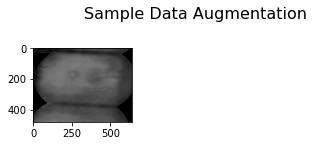

y Labels:  [[0. 0. 1.]]
sample img, max value:  0.5411765
sample img, min value:  0.0


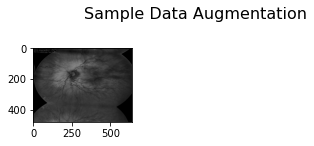

y Labels:  [[0. 0. 1.]]
sample img, max value:  0.5411765
sample img, min value:  0.0


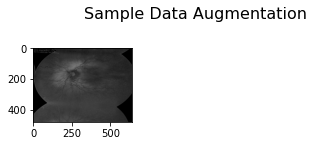

y Labels:  [[0. 0. 1.]]
sample img, max value:  0.5411765
sample img, min value:  0.0


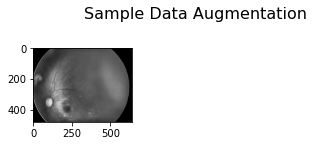

y Labels:  [[0. 0. 1.]]
sample img, max value:  0.9921569
sample img, min value:  0.0


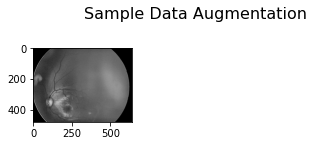

y Labels:  [[0. 0. 1.]]
sample img, max value:  0.9803922
sample img, min value:  0.0


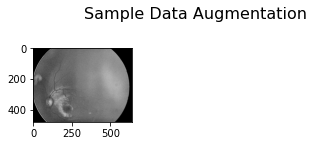

y Labels:  [[0. 0. 1.]]
sample img, max value:  0.9921569
sample img, min value:  0.0
########################## 

KerasTensor(type_spec=TensorSpec(shape=(2,), dtype=tf.int32, name=None), inferred_value=[None, 1280], name='tf.compat.v1.shape/Shape:0', description="created by layer 'tf.compat.v1.shape'")
# 

KerasTensor(type_spec=TensorSpec(shape=(4,), dtype=tf.int32, name=None), inferred_value=[None, 15, 20, 1280], name='tf.compat.v1.shape_1/Shape:0', description="created by layer 'tf.compat.v1.shape_1'")
# 

KerasTensor(type_spec=TensorSpec(shape=(2,), dtype=tf.int32, name=None), inferred_value=[None, 1280], name='tf.compat.v1.shape_2/Shape:0', description="created by layer 'tf.compat.v1.shape_2'")
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1123 (InputLayer)        [(None, 480, 640, 9  0           []         

 block1a_project_activation3 (A  (None, 240, 320, 24  0          ['block1a_project_bn3[0][0]']    
 ctivation)                     )                                                                 
                                                                                                  
 block1a_add1 (Add)             (None, 240, 320, 24  0           ['block1a_project_activation1[0][
                                )                                0]',                             
                                                                  'stem_activation1[0][0]']       
                                                                                                  
 block1a_add2 (Add)             (None, 240, 320, 24  0           ['block1a_project_activation2[0][
                                )                                0]',                             
                                                                  'stem_activation2[0][0]']       
          

                                                                                                  
 block2a_expand_activation3 (Ac  (None, 120, 160, 96  0          ['block2a_expand_bn3[0][0]']     
 tivation)                      )                                                                 
                                                                                                  
 block2a_project_conv1 (Conv2D)  (None, 120, 160, 48  4608       ['block2a_expand_activation1[0][0
                                )                                ]']                              
                                                                                                  
 block2a_project_conv2 (Conv2D)  (None, 120, 160, 48  4608       ['block2a_expand_activation2[0][0
                                )                                ]']                              
                                                                                                  
 block2a_p

                                )                                 'block2a_project_bn3[0][0]']    
                                                                                                  
 block2c_expand_conv1 (Conv2D)  (None, 120, 160, 19  82944       ['block2b_add1[0][0]']           
                                2)                                                                
                                                                                                  
 block2c_expand_conv2 (Conv2D)  (None, 120, 160, 19  82944       ['block2b_add2[0][0]']           
                                2)                                                                
                                                                                                  
 block2c_expand_conv3 (Conv2D)  (None, 120, 160, 19  82944       ['block2b_add3[0][0]']           
                                2)                                                                
          

 block2d_expand_activation1 (Ac  (None, 120, 160, 19  0          ['block2d_expand_bn1[0][0]']     
 tivation)                      2)                                                                
                                                                                                  
 block2d_expand_activation2 (Ac  (None, 120, 160, 19  0          ['block2d_expand_bn2[0][0]']     
 tivation)                      2)                                                                
                                                                                                  
 block2d_expand_activation3 (Ac  (None, 120, 160, 19  0          ['block2d_expand_bn3[0][0]']     
 tivation)                      2)                                                                
                                                                                                  
 block2d_project_conv1 (Conv2D)  (None, 120, 160, 48  9216       ['block2d_expand_activation1[0][0
          

                                                                                                  
 block3a_project_bn3 (BatchNorm  (None, 60, 80, 64)  256         ['block3a_project_conv3[0][0]']  
 alization)                                                                                       
                                                                                                  
 block3b_expand_conv1 (Conv2D)  (None, 60, 80, 256)  147456      ['block3a_project_bn1[0][0]']    
                                                                                                  
 block3b_expand_conv2 (Conv2D)  (None, 60, 80, 256)  147456      ['block3a_project_bn2[0][0]']    
                                                                                                  
 block3b_expand_conv3 (Conv2D)  (None, 60, 80, 256)  147456      ['block3a_project_bn3[0][0]']    
                                                                                                  
 block3b_e

 tivation)                                                                                        
                                                                                                  
 block3c_project_conv1 (Conv2D)  (None, 60, 80, 64)  16384       ['block3c_expand_activation1[0][0
                                                                 ]']                              
                                                                                                  
 block3c_project_conv2 (Conv2D)  (None, 60, 80, 64)  16384       ['block3c_expand_activation2[0][0
                                                                 ]']                              
                                                                                                  
 block3c_project_conv3 (Conv2D)  (None, 60, 80, 64)  16384       ['block3c_expand_activation3[0][0
                                                                 ]']                              
          

 block3d_add1 (Add)             (None, 60, 80, 64)   0           ['block3d_drop1[0][0]',          
                                                                  'block3c_add1[0][0]']           
                                                                                                  
 block3d_add2 (Add)             (None, 60, 80, 64)   0           ['block3d_drop2[0][0]',          
                                                                  'block3c_add2[0][0]']           
                                                                                                  
 block3d_add3 (Add)             (None, 60, 80, 64)   0           ['block3d_drop3[0][0]',          
                                                                  'block3c_add3[0][0]']           
                                                                                                  
 block4a_expand_conv1 (Conv2D)  (None, 60, 80, 256)  16384       ['block3d_add1[0][0]']           
          

 block4a_se_expand2 (Conv2D)    (None, 1, 1, 256)    4352        ['block4a_se_reduce2[0][0]']     
                                                                                                  
 block4a_se_expand3 (Conv2D)    (None, 1, 1, 256)    4352        ['block4a_se_reduce3[0][0]']     
                                                                                                  
 block4a_se_excite1 (Multiply)  (None, 30, 40, 256)  0           ['block4a_activation1[0][0]',    
                                                                  'block4a_se_expand1[0][0]']     
                                                                                                  
 block4a_se_excite2 (Multiply)  (None, 30, 40, 256)  0           ['block4a_activation2[0][0]',    
                                                                  'block4a_se_expand2[0][0]']     
                                                                                                  
 block4a_s

 ragePooling2D)                                                                                   
                                                                                                  
 block4b_se_squeeze3 (GlobalAve  (None, 512)         0           ['block4b_activation3[0][0]']    
 ragePooling2D)                                                                                   
                                                                                                  
 block4b_se_reshape1 (Reshape)  (None, 1, 1, 512)    0           ['block4b_se_squeeze1[0][0]']    
                                                                                                  
 block4b_se_reshape2 (Reshape)  (None, 1, 1, 512)    0           ['block4b_se_squeeze2[0][0]']    
                                                                                                  
 block4b_se_reshape3 (Reshape)  (None, 1, 1, 512)    0           ['block4b_se_squeeze3[0][0]']    
          

 block4c_expand_activation3 (Ac  (None, 30, 40, 512)  0          ['block4c_expand_bn3[0][0]']     
 tivation)                                                                                        
                                                                                                  
 block4c_dwconv21 (DepthwiseCon  (None, 30, 40, 512)  4608       ['block4c_expand_activation1[0][0
 v2D)                                                            ]']                              
                                                                                                  
 block4c_dwconv22 (DepthwiseCon  (None, 30, 40, 512)  4608       ['block4c_expand_activation2[0][0
 v2D)                                                            ]']                              
                                                                                                  
 block4c_dwconv23 (DepthwiseCon  (None, 30, 40, 512)  4608       ['block4c_expand_activation3[0][0
 v2D)     

 block4c_drop2 (Dropout)        (None, 30, 40, 128)  0           ['block4c_project_bn2[0][0]']    
                                                                                                  
 block4c_drop3 (Dropout)        (None, 30, 40, 128)  0           ['block4c_project_bn3[0][0]']    
                                                                                                  
 block4c_add1 (Add)             (None, 30, 40, 128)  0           ['block4c_drop1[0][0]',          
                                                                  'block4b_add1[0][0]']           
                                                                                                  
 block4c_add2 (Add)             (None, 30, 40, 128)  0           ['block4c_drop2[0][0]',          
                                                                  'block4b_add2[0][0]']           
                                                                                                  
 block4c_a

 block4d_se_reduce3 (Conv2D)    (None, 1, 1, 32)     16416       ['block4d_se_reshape3[0][0]']    
                                                                                                  
 block4d_se_expand1 (Conv2D)    (None, 1, 1, 512)    16896       ['block4d_se_reduce1[0][0]']     
                                                                                                  
 block4d_se_expand2 (Conv2D)    (None, 1, 1, 512)    16896       ['block4d_se_reduce2[0][0]']     
                                                                                                  
 block4d_se_expand3 (Conv2D)    (None, 1, 1, 512)    16896       ['block4d_se_reduce3[0][0]']     
                                                                                                  
 block4d_se_excite1 (Multiply)  (None, 30, 40, 512)  0           ['block4d_activation1[0][0]',    
                                                                  'block4d_se_expand1[0][0]']     
          

 block4e_bn2 (BatchNormalizatio  (None, 30, 40, 512)  2048       ['block4e_dwconv22[0][0]']       
 n)                                                                                               
                                                                                                  
 block4e_bn3 (BatchNormalizatio  (None, 30, 40, 512)  2048       ['block4e_dwconv23[0][0]']       
 n)                                                                                               
                                                                                                  
 block4e_activation1 (Activatio  (None, 30, 40, 512)  0          ['block4e_bn1[0][0]']            
 n)                                                                                               
                                                                                                  
 block4e_activation2 (Activatio  (None, 30, 40, 512)  0          ['block4e_bn2[0][0]']            
 n)       

 block4f_expand_conv2 (Conv2D)  (None, 30, 40, 512)  65536       ['block4e_add2[0][0]']           
                                                                                                  
 block4f_expand_conv3 (Conv2D)  (None, 30, 40, 512)  65536       ['block4e_add3[0][0]']           
                                                                                                  
 block4f_expand_bn1 (BatchNorma  (None, 30, 40, 512)  2048       ['block4f_expand_conv1[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4f_expand_bn2 (BatchNorma  (None, 30, 40, 512)  2048       ['block4f_expand_conv2[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4f_e

                                                                  'block4f_se_expand3[0][0]']     
                                                                                                  
 block4f_project_conv1 (Conv2D)  (None, 30, 40, 128)  65536      ['block4f_se_excite1[0][0]']     
                                                                                                  
 block4f_project_conv2 (Conv2D)  (None, 30, 40, 128)  65536      ['block4f_se_excite2[0][0]']     
                                                                                                  
 block4f_project_conv3 (Conv2D)  (None, 30, 40, 128)  65536      ['block4f_se_excite3[0][0]']     
                                                                                                  
 block4f_project_bn1 (BatchNorm  (None, 30, 40, 128)  512        ['block4f_project_conv1[0][0]']  
 alization)                                                                                       
          

 block5a_se_squeeze1 (GlobalAve  (None, 768)         0           ['block5a_activation1[0][0]']    
 ragePooling2D)                                                                                   
                                                                                                  
 block5a_se_squeeze2 (GlobalAve  (None, 768)         0           ['block5a_activation2[0][0]']    
 ragePooling2D)                                                                                   
                                                                                                  
 block5a_se_squeeze3 (GlobalAve  (None, 768)         0           ['block5a_activation3[0][0]']    
 ragePooling2D)                                                                                   
                                                                                                  
 block5a_se_reshape1 (Reshape)  (None, 1, 1, 768)    0           ['block5a_se_squeeze1[0][0]']    
          

                                                                                                  
 block5b_bn1 (BatchNormalizatio  (None, 30, 40, 960)  3840       ['block5b_dwconv21[0][0]']       
 n)                                                                                               
                                                                                                  
 block5b_bn2 (BatchNormalizatio  (None, 30, 40, 960)  3840       ['block5b_dwconv22[0][0]']       
 n)                                                                                               
                                                                                                  
 block5b_bn3 (BatchNormalizatio  (None, 30, 40, 960)  3840       ['block5b_dwconv23[0][0]']       
 n)                                                                                               
                                                                                                  
 block5b_a

                                                                  'block5a_project_bn3[0][0]']    
                                                                                                  
 block5c_expand_conv1 (Conv2D)  (None, 30, 40, 960)  153600      ['block5b_add1[0][0]']           
                                                                                                  
 block5c_expand_conv2 (Conv2D)  (None, 30, 40, 960)  153600      ['block5b_add2[0][0]']           
                                                                                                  
 block5c_expand_conv3 (Conv2D)  (None, 30, 40, 960)  153600      ['block5b_add3[0][0]']           
                                                                                                  
 block5c_expand_bn1 (BatchNorma  (None, 30, 40, 960)  3840       ['block5c_expand_conv1[0][0]']   
 lization)                                                                                        
          

 block5c_se_excite2 (Multiply)  (None, 30, 40, 960)  0           ['block5c_activation2[0][0]',    
                                                                  'block5c_se_expand2[0][0]']     
                                                                                                  
 block5c_se_excite3 (Multiply)  (None, 30, 40, 960)  0           ['block5c_activation3[0][0]',    
                                                                  'block5c_se_expand3[0][0]']     
                                                                                                  
 block5c_project_conv1 (Conv2D)  (None, 30, 40, 160)  153600     ['block5c_se_excite1[0][0]']     
                                                                                                  
 block5c_project_conv2 (Conv2D)  (None, 30, 40, 160)  153600     ['block5c_se_excite2[0][0]']     
                                                                                                  
 block5c_p

                                                                                                  
 block5d_activation3 (Activatio  (None, 30, 40, 960)  0          ['block5d_bn3[0][0]']            
 n)                                                                                               
                                                                                                  
 block5d_se_squeeze1 (GlobalAve  (None, 960)         0           ['block5d_activation1[0][0]']    
 ragePooling2D)                                                                                   
                                                                                                  
 block5d_se_squeeze2 (GlobalAve  (None, 960)         0           ['block5d_activation2[0][0]']    
 ragePooling2D)                                                                                   
                                                                                                  
 block5d_s

 lization)                                                                                        
                                                                                                  
 block5e_expand_activation1 (Ac  (None, 30, 40, 960)  0          ['block5e_expand_bn1[0][0]']     
 tivation)                                                                                        
                                                                                                  
 block5e_expand_activation2 (Ac  (None, 30, 40, 960)  0          ['block5e_expand_bn2[0][0]']     
 tivation)                                                                                        
                                                                                                  
 block5e_expand_activation3 (Ac  (None, 30, 40, 960)  0          ['block5e_expand_bn3[0][0]']     
 tivation)                                                                                        
          

 block5e_project_bn2 (BatchNorm  (None, 30, 40, 160)  640        ['block5e_project_conv2[0][0]']  
 alization)                                                                                       
                                                                                                  
 block5e_project_bn3 (BatchNorm  (None, 30, 40, 160)  640        ['block5e_project_conv3[0][0]']  
 alization)                                                                                       
                                                                                                  
 block5e_drop1 (Dropout)        (None, 30, 40, 160)  0           ['block5e_project_bn1[0][0]']    
                                                                                                  
 block5e_drop2 (Dropout)        (None, 30, 40, 160)  0           ['block5e_project_bn2[0][0]']    
                                                                                                  
 block5e_d

 block5f_se_reshape2 (Reshape)  (None, 1, 1, 960)    0           ['block5f_se_squeeze2[0][0]']    
                                                                                                  
 block5f_se_reshape3 (Reshape)  (None, 1, 1, 960)    0           ['block5f_se_squeeze3[0][0]']    
                                                                                                  
 block5f_se_reduce1 (Conv2D)    (None, 1, 1, 40)     38440       ['block5f_se_reshape1[0][0]']    
                                                                                                  
 block5f_se_reduce2 (Conv2D)    (None, 1, 1, 40)     38440       ['block5f_se_reshape2[0][0]']    
                                                                                                  
 block5f_se_reduce3 (Conv2D)    (None, 1, 1, 40)     38440       ['block5f_se_reshape3[0][0]']    
                                                                                                  
 block5f_s

 v2D)                                                            ]']                              
                                                                                                  
 block5g_dwconv23 (DepthwiseCon  (None, 30, 40, 960)  8640       ['block5g_expand_activation3[0][0
 v2D)                                                            ]']                              
                                                                                                  
 block5g_bn1 (BatchNormalizatio  (None, 30, 40, 960)  3840       ['block5g_dwconv21[0][0]']       
 n)                                                                                               
                                                                                                  
 block5g_bn2 (BatchNormalizatio  (None, 30, 40, 960)  3840       ['block5g_dwconv22[0][0]']       
 n)                                                                                               
          

 block5g_add2 (Add)             (None, 30, 40, 160)  0           ['block5g_drop2[0][0]',          
                                                                  'block5f_add2[0][0]']           
                                                                                                  
 block5g_add3 (Add)             (None, 30, 40, 160)  0           ['block5g_drop3[0][0]',          
                                                                  'block5f_add3[0][0]']           
                                                                                                  
 block5h_expand_conv1 (Conv2D)  (None, 30, 40, 960)  153600      ['block5g_add1[0][0]']           
                                                                                                  
 block5h_expand_conv2 (Conv2D)  (None, 30, 40, 960)  153600      ['block5g_add2[0][0]']           
                                                                                                  
 block5h_e

                                                                                                  
 block5h_se_excite1 (Multiply)  (None, 30, 40, 960)  0           ['block5h_activation1[0][0]',    
                                                                  'block5h_se_expand1[0][0]']     
                                                                                                  
 block5h_se_excite2 (Multiply)  (None, 30, 40, 960)  0           ['block5h_activation2[0][0]',    
                                                                  'block5h_se_expand2[0][0]']     
                                                                                                  
 block5h_se_excite3 (Multiply)  (None, 30, 40, 960)  0           ['block5h_activation3[0][0]',    
                                                                  'block5h_se_expand3[0][0]']     
                                                                                                  
 block5h_p

 n)                                                                                               
                                                                                                  
 block5i_activation2 (Activatio  (None, 30, 40, 960)  0          ['block5i_bn2[0][0]']            
 n)                                                                                               
                                                                                                  
 block5i_activation3 (Activatio  (None, 30, 40, 960)  0          ['block5i_bn3[0][0]']            
 n)                                                                                               
                                                                                                  
 block5i_se_squeeze1 (GlobalAve  (None, 960)         0           ['block5i_activation1[0][0]']    
 ragePooling2D)                                                                                   
          

 block6a_expand_bn2 (BatchNorma  (None, 30, 40, 960)  3840       ['block6a_expand_conv2[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6a_expand_bn3 (BatchNorma  (None, 30, 40, 960)  3840       ['block6a_expand_conv3[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6a_expand_activation1 (Ac  (None, 30, 40, 960)  0          ['block6a_expand_bn1[0][0]']     
 tivation)                                                                                        
                                                                                                  
 block6a_expand_activation2 (Ac  (None, 30, 40, 960)  0          ['block6a_expand_bn2[0][0]']     
 tivation)

                                                                                                  
 block6a_project_bn1 (BatchNorm  (None, 15, 20, 256)  1024       ['block6a_project_conv1[0][0]']  
 alization)                                                                                       
                                                                                                  
 block6a_project_bn2 (BatchNorm  (None, 15, 20, 256)  1024       ['block6a_project_conv2[0][0]']  
 alization)                                                                                       
                                                                                                  
 block6a_project_bn3 (BatchNorm  (None, 15, 20, 256)  1024       ['block6a_project_conv3[0][0]']  
 alization)                                                                                       
                                                                                                  
 block6b_e

 block6b_se_reduce3 (Conv2D)    (None, 1, 1, 64)     98368       ['block6b_se_reshape3[0][0]']    
                                                                                                  
 block6b_se_expand1 (Conv2D)    (None, 1, 1, 1536)   99840       ['block6b_se_reduce1[0][0]']     
                                                                                                  
 block6b_se_expand2 (Conv2D)    (None, 1, 1, 1536)   99840       ['block6b_se_reduce2[0][0]']     
                                                                                                  
 block6b_se_expand3 (Conv2D)    (None, 1, 1, 1536)   99840       ['block6b_se_reduce3[0][0]']     
                                                                                                  
 block6b_se_excite1 (Multiply)  (None, 15, 20, 1536  0           ['block6b_activation1[0][0]',    
                                )                                 'block6b_se_expand1[0][0]']     
          

 block6c_bn1 (BatchNormalizatio  (None, 15, 20, 1536  6144       ['block6c_dwconv21[0][0]']       
 n)                             )                                                                 
                                                                                                  
 block6c_bn2 (BatchNormalizatio  (None, 15, 20, 1536  6144       ['block6c_dwconv22[0][0]']       
 n)                             )                                                                 
                                                                                                  
 block6c_bn3 (BatchNormalizatio  (None, 15, 20, 1536  6144       ['block6c_dwconv23[0][0]']       
 n)                             )                                                                 
                                                                                                  
 block6c_activation1 (Activatio  (None, 15, 20, 1536  0          ['block6c_bn1[0][0]']            
 n)       

                                                                                                  
 block6d_expand_conv1 (Conv2D)  (None, 15, 20, 1536  393216      ['block6c_add1[0][0]']           
                                )                                                                 
                                                                                                  
 block6d_expand_conv2 (Conv2D)  (None, 15, 20, 1536  393216      ['block6c_add2[0][0]']           
                                )                                                                 
                                                                                                  
 block6d_expand_conv3 (Conv2D)  (None, 15, 20, 1536  393216      ['block6c_add3[0][0]']           
                                )                                                                 
                                                                                                  
 block6d_e

                                )                                 'block6d_se_expand1[0][0]']     
                                                                                                  
 block6d_se_excite2 (Multiply)  (None, 15, 20, 1536  0           ['block6d_activation2[0][0]',    
                                )                                 'block6d_se_expand2[0][0]']     
                                                                                                  
 block6d_se_excite3 (Multiply)  (None, 15, 20, 1536  0           ['block6d_activation3[0][0]',    
                                )                                 'block6d_se_expand3[0][0]']     
                                                                                                  
 block6d_project_conv1 (Conv2D)  (None, 15, 20, 256)  393216     ['block6d_se_excite1[0][0]']     
                                                                                                  
 block6d_p

 block6e_activation1 (Activatio  (None, 15, 20, 1536  0          ['block6e_bn1[0][0]']            
 n)                             )                                                                 
                                                                                                  
 block6e_activation2 (Activatio  (None, 15, 20, 1536  0          ['block6e_bn2[0][0]']            
 n)                             )                                                                 
                                                                                                  
 block6e_activation3 (Activatio  (None, 15, 20, 1536  0          ['block6e_bn3[0][0]']            
 n)                             )                                                                 
                                                                                                  
 block6e_se_squeeze1 (GlobalAve  (None, 1536)        0           ['block6e_activation1[0][0]']    
 ragePooli

                                                                                                  
 block6f_expand_bn1 (BatchNorma  (None, 15, 20, 1536  6144       ['block6f_expand_conv1[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 block6f_expand_bn2 (BatchNorma  (None, 15, 20, 1536  6144       ['block6f_expand_conv2[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 block6f_expand_bn3 (BatchNorma  (None, 15, 20, 1536  6144       ['block6f_expand_conv3[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 block6f_e

                                                                                                  
 block6f_project_conv2 (Conv2D)  (None, 15, 20, 256)  393216     ['block6f_se_excite2[0][0]']     
                                                                                                  
 block6f_project_conv3 (Conv2D)  (None, 15, 20, 256)  393216     ['block6f_se_excite3[0][0]']     
                                                                                                  
 block6f_project_bn1 (BatchNorm  (None, 15, 20, 256)  1024       ['block6f_project_conv1[0][0]']  
 alization)                                                                                       
                                                                                                  
 block6f_project_bn2 (BatchNorm  (None, 15, 20, 256)  1024       ['block6f_project_conv2[0][0]']  
 alization)                                                                                       
          

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



680/680 [==============================] - 414s 372ms/step - loss: 1.0786 - tp: 20.0000 - accuracy: 0.3750 - val_loss: 1.3449 - val_tp: 23.0000 - val_accuracy: 0.1088
Epoch 2/90
680/680 [==============================] - 251s 369ms/step - loss: 1.0295 - tp: 185.0000 - accuracy: 0.4684 - val_loss: 1.1578 - val_tp: 55.0000 - val_accuracy: 0.3206
Epoch 3/90
680/680 [==============================] - 253s 372ms/step - loss: 0.9577 - tp: 367.0000 - accuracy: 0.4956 - val_loss: 0.9956 - val_tp: 131.0000 - val_accuracy: 0.5059
Epoch 4/90
680/680 [==============================] - 255s 375ms/step - loss: 0.9443 - tp: 472.0000 - accuracy: 0.5051 - val_loss: 0.9108 - val_tp: 144.0000 - val_accuracy: 0.5824
Epoch 5/90
680/680 [==============================] - 255s 375ms/step - loss: 0.9343 - tp: 470.0000 - accuracy: 0.5221 - val_loss: 0.9682 - val_tp: 135.0000 - val_accuracy: 0.5500
Epoch 6/90
680/680 [==============================] - 254s 374ms/step - loss: 0.8940 - tp: 508.0000 - accuracy: 0.

680/680 [==============================] - 257s 378ms/step - loss: 0.4044 - tp: 1055.0000 - accuracy: 0.7926 - val_loss: 0.8744 - val_tp: 234.0000 - val_accuracy: 0.7029
Epoch 47/90
680/680 [==============================] - 256s 376ms/step - loss: 0.4392 - tp: 1026.0000 - accuracy: 0.7809 - val_loss: 0.9886 - val_tp: 219.0000 - val_accuracy: 0.6559
Epoch 48/90
680/680 [==============================] - 255s 374ms/step - loss: 0.4236 - tp: 1078.0000 - accuracy: 0.8022 - val_loss: 0.8240 - val_tp: 229.0000 - val_accuracy: 0.6765
Epoch 49/90
680/680 [==============================] - 253s 372ms/step - loss: 0.3794 - tp: 1077.0000 - accuracy: 0.8096 - val_loss: 0.9164 - val_tp: 223.0000 - val_accuracy: 0.6882
Epoch 50/90
680/680 [==============================] - 256s 377ms/step - loss: 0.3754 - tp: 1057.0000 - accuracy: 0.7956 - val_loss: 0.9583 - val_tp: 216.0000 - val_accuracy: 0.6529
Epoch 51/90
680/680 [==============================] - 251s 369ms/step - loss: 0.4045 - tp: 1071.0000 

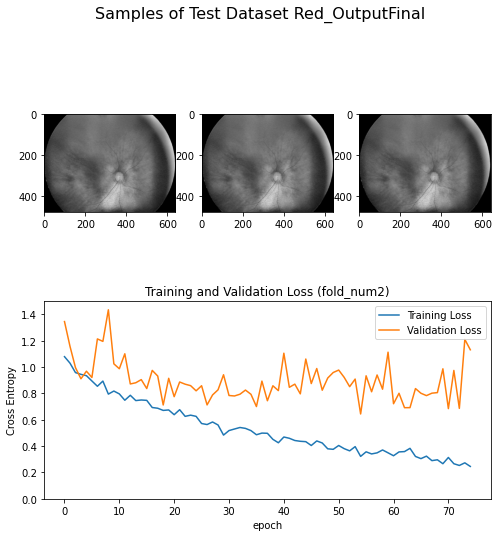

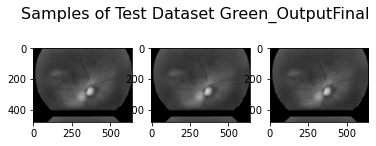

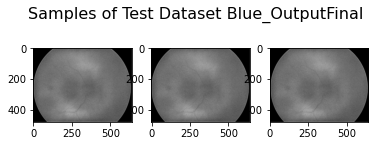

11/11 [==============================] - 17s 705ms/step
Saved 182 correct predictions and 158 incorrect predictions. Valid
Categorical Classification
---------------------
Confusion matrix, without normalization
[[115   7  73]
 [ 12   4   3]
 [ 55   8  63]]
[[115   7  73]
 [ 12   4   3]
 [ 55   8  63]]


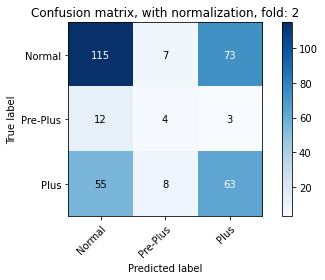

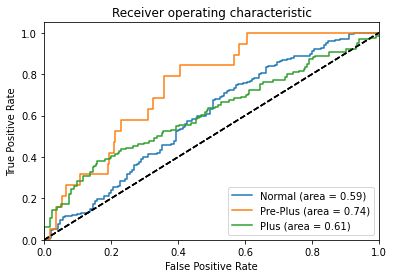

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15395171361966611299
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 48841162752
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
    link {
      device_id: 2
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 15786893894877712647
physical_device_desc: "device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:18:00.0, compute capability: 8.6"
xla_global_id: 416903419
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 48621879296
locality {
  bus_id: 1
  links {
    link {
      type: "StreamExecutor"
      strength: 1
    }
    link {
      device_id: 2
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 1268573814044576670
physical_device_desc: "device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:8a:00.0, compute capability: 8.6"
xla_global_id: 2144165316
, na

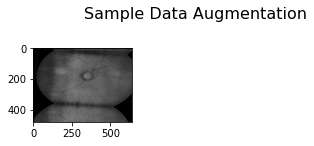

y Labels:  [[1. 0. 0.]]
sample img, max value:  0.5019608
sample img, min value:  0.0


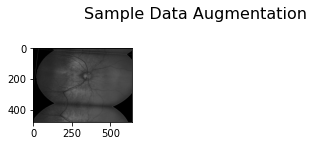

y Labels:  [[1. 0. 0.]]
sample img, max value:  0.45098042
sample img, min value:  0.0


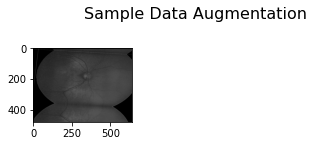

y Labels:  [[1. 0. 0.]]
sample img, max value:  0.37254903
sample img, min value:  0.0


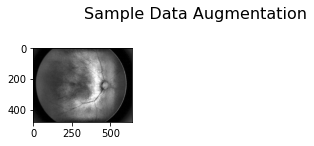

y Labels:  [[1. 0. 0.]]
sample img, max value:  1.0
sample img, min value:  0.0


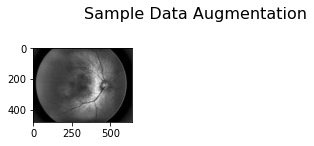

y Labels:  [[1. 0. 0.]]
sample img, max value:  0.97647065
sample img, min value:  0.0


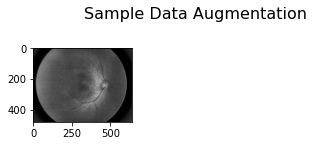

y Labels:  [[1. 0. 0.]]
sample img, max value:  0.7725491
sample img, min value:  0.0
########################## 

KerasTensor(type_spec=TensorSpec(shape=(2,), dtype=tf.int32, name=None), inferred_value=[None, 1280], name='tf.compat.v1.shape_3/Shape:0', description="created by layer 'tf.compat.v1.shape_3'")
# 

KerasTensor(type_spec=TensorSpec(shape=(4,), dtype=tf.int32, name=None), inferred_value=[None, 15, 20, 1280], name='tf.compat.v1.shape_4/Shape:0', description="created by layer 'tf.compat.v1.shape_4'")
# 

KerasTensor(type_spec=TensorSpec(shape=(2,), dtype=tf.int32, name=None), inferred_value=[None, 1280], name='tf.compat.v1.shape_5/Shape:0', description="created by layer 'tf.compat.v1.shape_5'")
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5123 (InputLayer)        [(None, 480, 640, 9  0           []     

 block1a_project_activation3 (A  (None, 240, 320, 24  0          ['block1a_project_bn3[0][0]']    
 ctivation)                     )                                                                 
                                                                                                  
 block1a_add1 (Add)             (None, 240, 320, 24  0           ['block1a_project_activation1[0][
                                )                                0]',                             
                                                                  'stem_activation1[0][0]']       
                                                                                                  
 block1a_add2 (Add)             (None, 240, 320, 24  0           ['block1a_project_activation2[0][
                                )                                0]',                             
                                                                  'stem_activation2[0][0]']       
          

                                                                                                  
 block2a_expand_activation3 (Ac  (None, 120, 160, 96  0          ['block2a_expand_bn3[0][0]']     
 tivation)                      )                                                                 
                                                                                                  
 block2a_project_conv1 (Conv2D)  (None, 120, 160, 48  4608       ['block2a_expand_activation1[0][0
                                )                                ]']                              
                                                                                                  
 block2a_project_conv2 (Conv2D)  (None, 120, 160, 48  4608       ['block2a_expand_activation2[0][0
                                )                                ]']                              
                                                                                                  
 block2a_p

                                )                                 'block2a_project_bn3[0][0]']    
                                                                                                  
 block2c_expand_conv1 (Conv2D)  (None, 120, 160, 19  82944       ['block2b_add1[0][0]']           
                                2)                                                                
                                                                                                  
 block2c_expand_conv2 (Conv2D)  (None, 120, 160, 19  82944       ['block2b_add2[0][0]']           
                                2)                                                                
                                                                                                  
 block2c_expand_conv3 (Conv2D)  (None, 120, 160, 19  82944       ['block2b_add3[0][0]']           
                                2)                                                                
          

 block2d_expand_activation1 (Ac  (None, 120, 160, 19  0          ['block2d_expand_bn1[0][0]']     
 tivation)                      2)                                                                
                                                                                                  
 block2d_expand_activation2 (Ac  (None, 120, 160, 19  0          ['block2d_expand_bn2[0][0]']     
 tivation)                      2)                                                                
                                                                                                  
 block2d_expand_activation3 (Ac  (None, 120, 160, 19  0          ['block2d_expand_bn3[0][0]']     
 tivation)                      2)                                                                
                                                                                                  
 block2d_project_conv1 (Conv2D)  (None, 120, 160, 48  9216       ['block2d_expand_activation1[0][0
          

                                                                                                  
 block3a_project_bn3 (BatchNorm  (None, 60, 80, 64)  256         ['block3a_project_conv3[0][0]']  
 alization)                                                                                       
                                                                                                  
 block3b_expand_conv1 (Conv2D)  (None, 60, 80, 256)  147456      ['block3a_project_bn1[0][0]']    
                                                                                                  
 block3b_expand_conv2 (Conv2D)  (None, 60, 80, 256)  147456      ['block3a_project_bn2[0][0]']    
                                                                                                  
 block3b_expand_conv3 (Conv2D)  (None, 60, 80, 256)  147456      ['block3a_project_bn3[0][0]']    
                                                                                                  
 block3b_e

 tivation)                                                                                        
                                                                                                  
 block3c_project_conv1 (Conv2D)  (None, 60, 80, 64)  16384       ['block3c_expand_activation1[0][0
                                                                 ]']                              
                                                                                                  
 block3c_project_conv2 (Conv2D)  (None, 60, 80, 64)  16384       ['block3c_expand_activation2[0][0
                                                                 ]']                              
                                                                                                  
 block3c_project_conv3 (Conv2D)  (None, 60, 80, 64)  16384       ['block3c_expand_activation3[0][0
                                                                 ]']                              
          

 block3d_add1 (Add)             (None, 60, 80, 64)   0           ['block3d_drop1[0][0]',          
                                                                  'block3c_add1[0][0]']           
                                                                                                  
 block3d_add2 (Add)             (None, 60, 80, 64)   0           ['block3d_drop2[0][0]',          
                                                                  'block3c_add2[0][0]']           
                                                                                                  
 block3d_add3 (Add)             (None, 60, 80, 64)   0           ['block3d_drop3[0][0]',          
                                                                  'block3c_add3[0][0]']           
                                                                                                  
 block4a_expand_conv1 (Conv2D)  (None, 60, 80, 256)  16384       ['block3d_add1[0][0]']           
          

 block4a_se_expand2 (Conv2D)    (None, 1, 1, 256)    4352        ['block4a_se_reduce2[0][0]']     
                                                                                                  
 block4a_se_expand3 (Conv2D)    (None, 1, 1, 256)    4352        ['block4a_se_reduce3[0][0]']     
                                                                                                  
 block4a_se_excite1 (Multiply)  (None, 30, 40, 256)  0           ['block4a_activation1[0][0]',    
                                                                  'block4a_se_expand1[0][0]']     
                                                                                                  
 block4a_se_excite2 (Multiply)  (None, 30, 40, 256)  0           ['block4a_activation2[0][0]',    
                                                                  'block4a_se_expand2[0][0]']     
                                                                                                  
 block4a_s

 ragePooling2D)                                                                                   
                                                                                                  
 block4b_se_squeeze3 (GlobalAve  (None, 512)         0           ['block4b_activation3[0][0]']    
 ragePooling2D)                                                                                   
                                                                                                  
 block4b_se_reshape1 (Reshape)  (None, 1, 1, 512)    0           ['block4b_se_squeeze1[0][0]']    
                                                                                                  
 block4b_se_reshape2 (Reshape)  (None, 1, 1, 512)    0           ['block4b_se_squeeze2[0][0]']    
                                                                                                  
 block4b_se_reshape3 (Reshape)  (None, 1, 1, 512)    0           ['block4b_se_squeeze3[0][0]']    
          

 block4c_expand_activation3 (Ac  (None, 30, 40, 512)  0          ['block4c_expand_bn3[0][0]']     
 tivation)                                                                                        
                                                                                                  
 block4c_dwconv21 (DepthwiseCon  (None, 30, 40, 512)  4608       ['block4c_expand_activation1[0][0
 v2D)                                                            ]']                              
                                                                                                  
 block4c_dwconv22 (DepthwiseCon  (None, 30, 40, 512)  4608       ['block4c_expand_activation2[0][0
 v2D)                                                            ]']                              
                                                                                                  
 block4c_dwconv23 (DepthwiseCon  (None, 30, 40, 512)  4608       ['block4c_expand_activation3[0][0
 v2D)     

 block4c_drop2 (Dropout)        (None, 30, 40, 128)  0           ['block4c_project_bn2[0][0]']    
                                                                                                  
 block4c_drop3 (Dropout)        (None, 30, 40, 128)  0           ['block4c_project_bn3[0][0]']    
                                                                                                  
 block4c_add1 (Add)             (None, 30, 40, 128)  0           ['block4c_drop1[0][0]',          
                                                                  'block4b_add1[0][0]']           
                                                                                                  
 block4c_add2 (Add)             (None, 30, 40, 128)  0           ['block4c_drop2[0][0]',          
                                                                  'block4b_add2[0][0]']           
                                                                                                  
 block4c_a

 block4d_se_reduce3 (Conv2D)    (None, 1, 1, 32)     16416       ['block4d_se_reshape3[0][0]']    
                                                                                                  
 block4d_se_expand1 (Conv2D)    (None, 1, 1, 512)    16896       ['block4d_se_reduce1[0][0]']     
                                                                                                  
 block4d_se_expand2 (Conv2D)    (None, 1, 1, 512)    16896       ['block4d_se_reduce2[0][0]']     
                                                                                                  
 block4d_se_expand3 (Conv2D)    (None, 1, 1, 512)    16896       ['block4d_se_reduce3[0][0]']     
                                                                                                  
 block4d_se_excite1 (Multiply)  (None, 30, 40, 512)  0           ['block4d_activation1[0][0]',    
                                                                  'block4d_se_expand1[0][0]']     
          

 block4e_bn2 (BatchNormalizatio  (None, 30, 40, 512)  2048       ['block4e_dwconv22[0][0]']       
 n)                                                                                               
                                                                                                  
 block4e_bn3 (BatchNormalizatio  (None, 30, 40, 512)  2048       ['block4e_dwconv23[0][0]']       
 n)                                                                                               
                                                                                                  
 block4e_activation1 (Activatio  (None, 30, 40, 512)  0          ['block4e_bn1[0][0]']            
 n)                                                                                               
                                                                                                  
 block4e_activation2 (Activatio  (None, 30, 40, 512)  0          ['block4e_bn2[0][0]']            
 n)       

 block4f_expand_conv2 (Conv2D)  (None, 30, 40, 512)  65536       ['block4e_add2[0][0]']           
                                                                                                  
 block4f_expand_conv3 (Conv2D)  (None, 30, 40, 512)  65536       ['block4e_add3[0][0]']           
                                                                                                  
 block4f_expand_bn1 (BatchNorma  (None, 30, 40, 512)  2048       ['block4f_expand_conv1[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4f_expand_bn2 (BatchNorma  (None, 30, 40, 512)  2048       ['block4f_expand_conv2[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4f_e

                                                                  'block4f_se_expand3[0][0]']     
                                                                                                  
 block4f_project_conv1 (Conv2D)  (None, 30, 40, 128)  65536      ['block4f_se_excite1[0][0]']     
                                                                                                  
 block4f_project_conv2 (Conv2D)  (None, 30, 40, 128)  65536      ['block4f_se_excite2[0][0]']     
                                                                                                  
 block4f_project_conv3 (Conv2D)  (None, 30, 40, 128)  65536      ['block4f_se_excite3[0][0]']     
                                                                                                  
 block4f_project_bn1 (BatchNorm  (None, 30, 40, 128)  512        ['block4f_project_conv1[0][0]']  
 alization)                                                                                       
          

 block5a_se_squeeze1 (GlobalAve  (None, 768)         0           ['block5a_activation1[0][0]']    
 ragePooling2D)                                                                                   
                                                                                                  
 block5a_se_squeeze2 (GlobalAve  (None, 768)         0           ['block5a_activation2[0][0]']    
 ragePooling2D)                                                                                   
                                                                                                  
 block5a_se_squeeze3 (GlobalAve  (None, 768)         0           ['block5a_activation3[0][0]']    
 ragePooling2D)                                                                                   
                                                                                                  
 block5a_se_reshape1 (Reshape)  (None, 1, 1, 768)    0           ['block5a_se_squeeze1[0][0]']    
          

                                                                                                  
 block5b_bn1 (BatchNormalizatio  (None, 30, 40, 960)  3840       ['block5b_dwconv21[0][0]']       
 n)                                                                                               
                                                                                                  
 block5b_bn2 (BatchNormalizatio  (None, 30, 40, 960)  3840       ['block5b_dwconv22[0][0]']       
 n)                                                                                               
                                                                                                  
 block5b_bn3 (BatchNormalizatio  (None, 30, 40, 960)  3840       ['block5b_dwconv23[0][0]']       
 n)                                                                                               
                                                                                                  
 block5b_a

                                                                  'block5a_project_bn3[0][0]']    
                                                                                                  
 block5c_expand_conv1 (Conv2D)  (None, 30, 40, 960)  153600      ['block5b_add1[0][0]']           
                                                                                                  
 block5c_expand_conv2 (Conv2D)  (None, 30, 40, 960)  153600      ['block5b_add2[0][0]']           
                                                                                                  
 block5c_expand_conv3 (Conv2D)  (None, 30, 40, 960)  153600      ['block5b_add3[0][0]']           
                                                                                                  
 block5c_expand_bn1 (BatchNorma  (None, 30, 40, 960)  3840       ['block5c_expand_conv1[0][0]']   
 lization)                                                                                        
          

 block5c_se_excite2 (Multiply)  (None, 30, 40, 960)  0           ['block5c_activation2[0][0]',    
                                                                  'block5c_se_expand2[0][0]']     
                                                                                                  
 block5c_se_excite3 (Multiply)  (None, 30, 40, 960)  0           ['block5c_activation3[0][0]',    
                                                                  'block5c_se_expand3[0][0]']     
                                                                                                  
 block5c_project_conv1 (Conv2D)  (None, 30, 40, 160)  153600     ['block5c_se_excite1[0][0]']     
                                                                                                  
 block5c_project_conv2 (Conv2D)  (None, 30, 40, 160)  153600     ['block5c_se_excite2[0][0]']     
                                                                                                  
 block5c_p

                                                                                                  
 block5d_activation3 (Activatio  (None, 30, 40, 960)  0          ['block5d_bn3[0][0]']            
 n)                                                                                               
                                                                                                  
 block5d_se_squeeze1 (GlobalAve  (None, 960)         0           ['block5d_activation1[0][0]']    
 ragePooling2D)                                                                                   
                                                                                                  
 block5d_se_squeeze2 (GlobalAve  (None, 960)         0           ['block5d_activation2[0][0]']    
 ragePooling2D)                                                                                   
                                                                                                  
 block5d_s

 lization)                                                                                        
                                                                                                  
 block5e_expand_activation1 (Ac  (None, 30, 40, 960)  0          ['block5e_expand_bn1[0][0]']     
 tivation)                                                                                        
                                                                                                  
 block5e_expand_activation2 (Ac  (None, 30, 40, 960)  0          ['block5e_expand_bn2[0][0]']     
 tivation)                                                                                        
                                                                                                  
 block5e_expand_activation3 (Ac  (None, 30, 40, 960)  0          ['block5e_expand_bn3[0][0]']     
 tivation)                                                                                        
          

 block5e_project_bn2 (BatchNorm  (None, 30, 40, 160)  640        ['block5e_project_conv2[0][0]']  
 alization)                                                                                       
                                                                                                  
 block5e_project_bn3 (BatchNorm  (None, 30, 40, 160)  640        ['block5e_project_conv3[0][0]']  
 alization)                                                                                       
                                                                                                  
 block5e_drop1 (Dropout)        (None, 30, 40, 160)  0           ['block5e_project_bn1[0][0]']    
                                                                                                  
 block5e_drop2 (Dropout)        (None, 30, 40, 160)  0           ['block5e_project_bn2[0][0]']    
                                                                                                  
 block5e_d

 block5f_se_reshape2 (Reshape)  (None, 1, 1, 960)    0           ['block5f_se_squeeze2[0][0]']    
                                                                                                  
 block5f_se_reshape3 (Reshape)  (None, 1, 1, 960)    0           ['block5f_se_squeeze3[0][0]']    
                                                                                                  
 block5f_se_reduce1 (Conv2D)    (None, 1, 1, 40)     38440       ['block5f_se_reshape1[0][0]']    
                                                                                                  
 block5f_se_reduce2 (Conv2D)    (None, 1, 1, 40)     38440       ['block5f_se_reshape2[0][0]']    
                                                                                                  
 block5f_se_reduce3 (Conv2D)    (None, 1, 1, 40)     38440       ['block5f_se_reshape3[0][0]']    
                                                                                                  
 block5f_s

 v2D)                                                            ]']                              
                                                                                                  
 block5g_dwconv23 (DepthwiseCon  (None, 30, 40, 960)  8640       ['block5g_expand_activation3[0][0
 v2D)                                                            ]']                              
                                                                                                  
 block5g_bn1 (BatchNormalizatio  (None, 30, 40, 960)  3840       ['block5g_dwconv21[0][0]']       
 n)                                                                                               
                                                                                                  
 block5g_bn2 (BatchNormalizatio  (None, 30, 40, 960)  3840       ['block5g_dwconv22[0][0]']       
 n)                                                                                               
          

 block5g_add2 (Add)             (None, 30, 40, 160)  0           ['block5g_drop2[0][0]',          
                                                                  'block5f_add2[0][0]']           
                                                                                                  
 block5g_add3 (Add)             (None, 30, 40, 160)  0           ['block5g_drop3[0][0]',          
                                                                  'block5f_add3[0][0]']           
                                                                                                  
 block5h_expand_conv1 (Conv2D)  (None, 30, 40, 960)  153600      ['block5g_add1[0][0]']           
                                                                                                  
 block5h_expand_conv2 (Conv2D)  (None, 30, 40, 960)  153600      ['block5g_add2[0][0]']           
                                                                                                  
 block5h_e

                                                                                                  
 block5h_se_excite1 (Multiply)  (None, 30, 40, 960)  0           ['block5h_activation1[0][0]',    
                                                                  'block5h_se_expand1[0][0]']     
                                                                                                  
 block5h_se_excite2 (Multiply)  (None, 30, 40, 960)  0           ['block5h_activation2[0][0]',    
                                                                  'block5h_se_expand2[0][0]']     
                                                                                                  
 block5h_se_excite3 (Multiply)  (None, 30, 40, 960)  0           ['block5h_activation3[0][0]',    
                                                                  'block5h_se_expand3[0][0]']     
                                                                                                  
 block5h_p

 n)                                                                                               
                                                                                                  
 block5i_activation2 (Activatio  (None, 30, 40, 960)  0          ['block5i_bn2[0][0]']            
 n)                                                                                               
                                                                                                  
 block5i_activation3 (Activatio  (None, 30, 40, 960)  0          ['block5i_bn3[0][0]']            
 n)                                                                                               
                                                                                                  
 block5i_se_squeeze1 (GlobalAve  (None, 960)         0           ['block5i_activation1[0][0]']    
 ragePooling2D)                                                                                   
          

 block6a_expand_bn2 (BatchNorma  (None, 30, 40, 960)  3840       ['block6a_expand_conv2[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6a_expand_bn3 (BatchNorma  (None, 30, 40, 960)  3840       ['block6a_expand_conv3[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6a_expand_activation1 (Ac  (None, 30, 40, 960)  0          ['block6a_expand_bn1[0][0]']     
 tivation)                                                                                        
                                                                                                  
 block6a_expand_activation2 (Ac  (None, 30, 40, 960)  0          ['block6a_expand_bn2[0][0]']     
 tivation)

                                                                                                  
 block6a_project_bn1 (BatchNorm  (None, 15, 20, 256)  1024       ['block6a_project_conv1[0][0]']  
 alization)                                                                                       
                                                                                                  
 block6a_project_bn2 (BatchNorm  (None, 15, 20, 256)  1024       ['block6a_project_conv2[0][0]']  
 alization)                                                                                       
                                                                                                  
 block6a_project_bn3 (BatchNorm  (None, 15, 20, 256)  1024       ['block6a_project_conv3[0][0]']  
 alization)                                                                                       
                                                                                                  
 block6b_e

 block6b_se_reduce3 (Conv2D)    (None, 1, 1, 64)     98368       ['block6b_se_reshape3[0][0]']    
                                                                                                  
 block6b_se_expand1 (Conv2D)    (None, 1, 1, 1536)   99840       ['block6b_se_reduce1[0][0]']     
                                                                                                  
 block6b_se_expand2 (Conv2D)    (None, 1, 1, 1536)   99840       ['block6b_se_reduce2[0][0]']     
                                                                                                  
 block6b_se_expand3 (Conv2D)    (None, 1, 1, 1536)   99840       ['block6b_se_reduce3[0][0]']     
                                                                                                  
 block6b_se_excite1 (Multiply)  (None, 15, 20, 1536  0           ['block6b_activation1[0][0]',    
                                )                                 'block6b_se_expand1[0][0]']     
          

 block6c_bn1 (BatchNormalizatio  (None, 15, 20, 1536  6144       ['block6c_dwconv21[0][0]']       
 n)                             )                                                                 
                                                                                                  
 block6c_bn2 (BatchNormalizatio  (None, 15, 20, 1536  6144       ['block6c_dwconv22[0][0]']       
 n)                             )                                                                 
                                                                                                  
 block6c_bn3 (BatchNormalizatio  (None, 15, 20, 1536  6144       ['block6c_dwconv23[0][0]']       
 n)                             )                                                                 
                                                                                                  
 block6c_activation1 (Activatio  (None, 15, 20, 1536  0          ['block6c_bn1[0][0]']            
 n)       

                                                                                                  
 block6d_expand_conv1 (Conv2D)  (None, 15, 20, 1536  393216      ['block6c_add1[0][0]']           
                                )                                                                 
                                                                                                  
 block6d_expand_conv2 (Conv2D)  (None, 15, 20, 1536  393216      ['block6c_add2[0][0]']           
                                )                                                                 
                                                                                                  
 block6d_expand_conv3 (Conv2D)  (None, 15, 20, 1536  393216      ['block6c_add3[0][0]']           
                                )                                                                 
                                                                                                  
 block6d_e

                                )                                 'block6d_se_expand1[0][0]']     
                                                                                                  
 block6d_se_excite2 (Multiply)  (None, 15, 20, 1536  0           ['block6d_activation2[0][0]',    
                                )                                 'block6d_se_expand2[0][0]']     
                                                                                                  
 block6d_se_excite3 (Multiply)  (None, 15, 20, 1536  0           ['block6d_activation3[0][0]',    
                                )                                 'block6d_se_expand3[0][0]']     
                                                                                                  
 block6d_project_conv1 (Conv2D)  (None, 15, 20, 256)  393216     ['block6d_se_excite1[0][0]']     
                                                                                                  
 block6d_p

 block6e_activation1 (Activatio  (None, 15, 20, 1536  0          ['block6e_bn1[0][0]']            
 n)                             )                                                                 
                                                                                                  
 block6e_activation2 (Activatio  (None, 15, 20, 1536  0          ['block6e_bn2[0][0]']            
 n)                             )                                                                 
                                                                                                  
 block6e_activation3 (Activatio  (None, 15, 20, 1536  0          ['block6e_bn3[0][0]']            
 n)                             )                                                                 
                                                                                                  
 block6e_se_squeeze1 (GlobalAve  (None, 1536)        0           ['block6e_activation1[0][0]']    
 ragePooli

                                                                                                  
 block6f_expand_bn1 (BatchNorma  (None, 15, 20, 1536  6144       ['block6f_expand_conv1[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 block6f_expand_bn2 (BatchNorma  (None, 15, 20, 1536  6144       ['block6f_expand_conv2[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 block6f_expand_bn3 (BatchNorma  (None, 15, 20, 1536  6144       ['block6f_expand_conv3[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 block6f_e

                                                                                                  
 block6f_project_conv2 (Conv2D)  (None, 15, 20, 256)  393216     ['block6f_se_excite2[0][0]']     
                                                                                                  
 block6f_project_conv3 (Conv2D)  (None, 15, 20, 256)  393216     ['block6f_se_excite3[0][0]']     
                                                                                                  
 block6f_project_bn1 (BatchNorm  (None, 15, 20, 256)  1024       ['block6f_project_conv1[0][0]']  
 alization)                                                                                       
                                                                                                  
 block6f_project_bn2 (BatchNorm  (None, 15, 20, 256)  1024       ['block6f_project_conv2[0][0]']  
 alization)                                                                                       
          

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



680/680 [==============================] - 421s 382ms/step - loss: 1.0943 - tp: 35.0000 - accuracy: 0.4507 - val_loss: 1.1620 - val_tp: 8.0000 - val_accuracy: 0.2206
Epoch 2/90
680/680 [==============================] - 248s 365ms/step - loss: 1.0302 - tp: 150.0000 - accuracy: 0.5029 - val_loss: 1.1121 - val_tp: 36.0000 - val_accuracy: 0.3382
Epoch 3/90
680/680 [==============================] - 258s 379ms/step - loss: 0.9691 - tp: 371.0000 - accuracy: 0.5353 - val_loss: 0.9596 - val_tp: 118.0000 - val_accuracy: 0.5235
Epoch 4/90
680/680 [==============================] - 255s 376ms/step - loss: 0.9460 - tp: 466.0000 - accuracy: 0.5390 - val_loss: 1.1487 - val_tp: 72.0000 - val_accuracy: 0.3382
Epoch 5/90
680/680 [==============================] - 256s 377ms/step - loss: 0.8878 - tp: 503.0000 - accuracy: 0.5213 - val_loss: 1.1055 - val_tp: 92.0000 - val_accuracy: 0.4059
Epoch 6/90
680/680 [==============================] - 259s 381ms/step - loss: 0.8453 - tp: 609.0000 - accuracy: 0.572

680/680 [==============================] - 258s 379ms/step - loss: 0.3697 - tp: 1084.0000 - accuracy: 0.8066 - val_loss: 0.7554 - val_tp: 230.0000 - val_accuracy: 0.6853
Epoch 47/90
680/680 [==============================] - 258s 379ms/step - loss: 0.4363 - tp: 1085.0000 - accuracy: 0.8125 - val_loss: 0.6715 - val_tp: 233.0000 - val_accuracy: 0.7059
Epoch 48/90
680/680 [==============================] - 258s 379ms/step - loss: 0.4084 - tp: 1049.0000 - accuracy: 0.7860 - val_loss: 0.7605 - val_tp: 226.0000 - val_accuracy: 0.6765
Epoch 49/90
680/680 [==============================] - 256s 376ms/step - loss: 0.3855 - tp: 1065.0000 - accuracy: 0.7978 - val_loss: 0.7189 - val_tp: 234.0000 - val_accuracy: 0.7176
Epoch 50/90
680/680 [==============================] - 260s 382ms/step - loss: 0.3749 - tp: 1078.0000 - accuracy: 0.8118 - val_loss: 0.6623 - val_tp: 236.0000 - val_accuracy: 0.7088
Epoch 51/90
680/680 [==============================] - 257s 378ms/step - loss: 0.3620 - tp: 1104.0000 

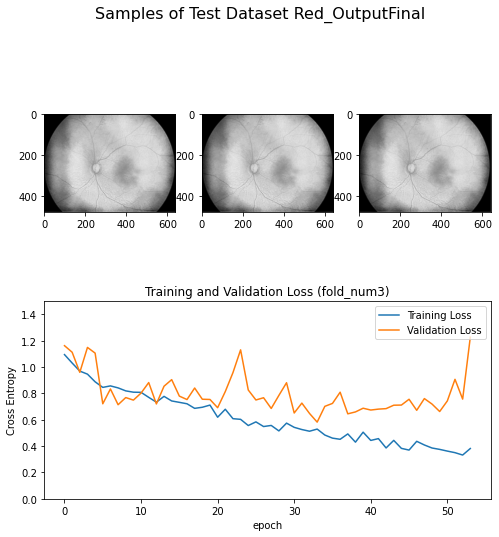

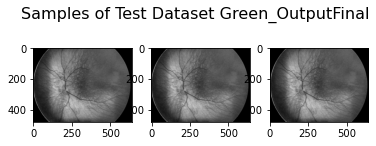

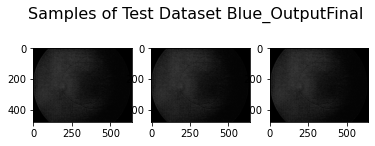

11/11 [==============================] - 12s 600ms/step
Saved 168 correct predictions and 172 incorrect predictions. Valid
Categorical Classification
---------------------
Confusion matrix, without normalization
[[88 22 84]
 [ 8  4  8]
 [40 10 76]]
[[88 22 84]
 [ 8  4  8]
 [40 10 76]]


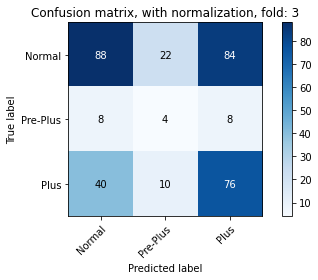

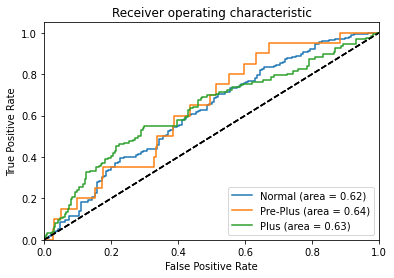

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6411379672487637918
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 48841162752
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
    link {
      device_id: 2
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 3760760024089798776
physical_device_desc: "device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:18:00.0, compute capability: 8.6"
xla_global_id: 416903419
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 48621879296
locality {
  bus_id: 1
  links {
    link {
      type: "StreamExecutor"
      strength: 1
    }
    link {
      device_id: 2
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 8450265369142556855
physical_device_desc: "device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:8a:00.0, compute capability: 8.6"
xla_global_id: 2144165316
, name

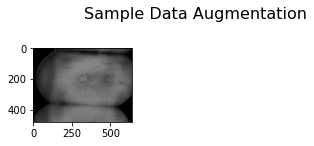

y Labels:  [[1. 0. 0.]]
sample img, max value:  0.54509807
sample img, min value:  0.0


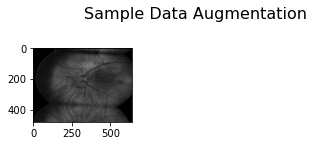

y Labels:  [[1. 0. 0.]]
sample img, max value:  0.5058824
sample img, min value:  0.0


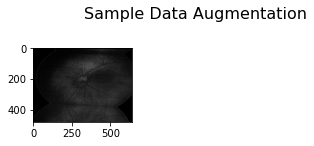

y Labels:  [[1. 0. 0.]]
sample img, max value:  0.37254903
sample img, min value:  0.0


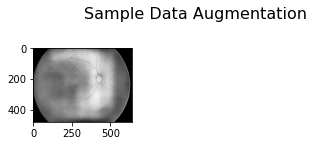

y Labels:  [[1. 0. 0.]]
sample img, max value:  0.98823535
sample img, min value:  0.0


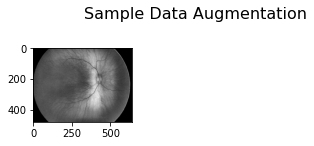

y Labels:  [[1. 0. 0.]]
sample img, max value:  0.9176471
sample img, min value:  0.0


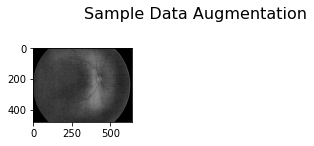

y Labels:  [[1. 0. 0.]]
sample img, max value:  0.67058825
sample img, min value:  0.0
########################## 

KerasTensor(type_spec=TensorSpec(shape=(2,), dtype=tf.int32, name=None), inferred_value=[None, 1280], name='tf.compat.v1.shape_6/Shape:0', description="created by layer 'tf.compat.v1.shape_6'")
# 

KerasTensor(type_spec=TensorSpec(shape=(4,), dtype=tf.int32, name=None), inferred_value=[None, 15, 20, 1280], name='tf.compat.v1.shape_7/Shape:0', description="created by layer 'tf.compat.v1.shape_7'")
# 

KerasTensor(type_spec=TensorSpec(shape=(2,), dtype=tf.int32, name=None), inferred_value=[None, 1280], name='tf.compat.v1.shape_8/Shape:0', description="created by layer 'tf.compat.v1.shape_8'")
Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9123 (InputLayer)        [(None, 480, 640, 9  0           []   

 block1a_project_activation3 (A  (None, 240, 320, 24  0          ['block1a_project_bn3[0][0]']    
 ctivation)                     )                                                                 
                                                                                                  
 block1a_add1 (Add)             (None, 240, 320, 24  0           ['block1a_project_activation1[0][
                                )                                0]',                             
                                                                  'stem_activation1[0][0]']       
                                                                                                  
 block1a_add2 (Add)             (None, 240, 320, 24  0           ['block1a_project_activation2[0][
                                )                                0]',                             
                                                                  'stem_activation2[0][0]']       
          

                                                                                                  
 block2a_expand_activation3 (Ac  (None, 120, 160, 96  0          ['block2a_expand_bn3[0][0]']     
 tivation)                      )                                                                 
                                                                                                  
 block2a_project_conv1 (Conv2D)  (None, 120, 160, 48  4608       ['block2a_expand_activation1[0][0
                                )                                ]']                              
                                                                                                  
 block2a_project_conv2 (Conv2D)  (None, 120, 160, 48  4608       ['block2a_expand_activation2[0][0
                                )                                ]']                              
                                                                                                  
 block2a_p

                                )                                 'block2a_project_bn3[0][0]']    
                                                                                                  
 block2c_expand_conv1 (Conv2D)  (None, 120, 160, 19  82944       ['block2b_add1[0][0]']           
                                2)                                                                
                                                                                                  
 block2c_expand_conv2 (Conv2D)  (None, 120, 160, 19  82944       ['block2b_add2[0][0]']           
                                2)                                                                
                                                                                                  
 block2c_expand_conv3 (Conv2D)  (None, 120, 160, 19  82944       ['block2b_add3[0][0]']           
                                2)                                                                
          

 block2d_expand_activation1 (Ac  (None, 120, 160, 19  0          ['block2d_expand_bn1[0][0]']     
 tivation)                      2)                                                                
                                                                                                  
 block2d_expand_activation2 (Ac  (None, 120, 160, 19  0          ['block2d_expand_bn2[0][0]']     
 tivation)                      2)                                                                
                                                                                                  
 block2d_expand_activation3 (Ac  (None, 120, 160, 19  0          ['block2d_expand_bn3[0][0]']     
 tivation)                      2)                                                                
                                                                                                  
 block2d_project_conv1 (Conv2D)  (None, 120, 160, 48  9216       ['block2d_expand_activation1[0][0
          

                                                                                                  
 block3a_project_bn3 (BatchNorm  (None, 60, 80, 64)  256         ['block3a_project_conv3[0][0]']  
 alization)                                                                                       
                                                                                                  
 block3b_expand_conv1 (Conv2D)  (None, 60, 80, 256)  147456      ['block3a_project_bn1[0][0]']    
                                                                                                  
 block3b_expand_conv2 (Conv2D)  (None, 60, 80, 256)  147456      ['block3a_project_bn2[0][0]']    
                                                                                                  
 block3b_expand_conv3 (Conv2D)  (None, 60, 80, 256)  147456      ['block3a_project_bn3[0][0]']    
                                                                                                  
 block3b_e

 tivation)                                                                                        
                                                                                                  
 block3c_project_conv1 (Conv2D)  (None, 60, 80, 64)  16384       ['block3c_expand_activation1[0][0
                                                                 ]']                              
                                                                                                  
 block3c_project_conv2 (Conv2D)  (None, 60, 80, 64)  16384       ['block3c_expand_activation2[0][0
                                                                 ]']                              
                                                                                                  
 block3c_project_conv3 (Conv2D)  (None, 60, 80, 64)  16384       ['block3c_expand_activation3[0][0
                                                                 ]']                              
          

 block3d_add1 (Add)             (None, 60, 80, 64)   0           ['block3d_drop1[0][0]',          
                                                                  'block3c_add1[0][0]']           
                                                                                                  
 block3d_add2 (Add)             (None, 60, 80, 64)   0           ['block3d_drop2[0][0]',          
                                                                  'block3c_add2[0][0]']           
                                                                                                  
 block3d_add3 (Add)             (None, 60, 80, 64)   0           ['block3d_drop3[0][0]',          
                                                                  'block3c_add3[0][0]']           
                                                                                                  
 block4a_expand_conv1 (Conv2D)  (None, 60, 80, 256)  16384       ['block3d_add1[0][0]']           
          

 block4a_se_expand2 (Conv2D)    (None, 1, 1, 256)    4352        ['block4a_se_reduce2[0][0]']     
                                                                                                  
 block4a_se_expand3 (Conv2D)    (None, 1, 1, 256)    4352        ['block4a_se_reduce3[0][0]']     
                                                                                                  
 block4a_se_excite1 (Multiply)  (None, 30, 40, 256)  0           ['block4a_activation1[0][0]',    
                                                                  'block4a_se_expand1[0][0]']     
                                                                                                  
 block4a_se_excite2 (Multiply)  (None, 30, 40, 256)  0           ['block4a_activation2[0][0]',    
                                                                  'block4a_se_expand2[0][0]']     
                                                                                                  
 block4a_s

 ragePooling2D)                                                                                   
                                                                                                  
 block4b_se_squeeze3 (GlobalAve  (None, 512)         0           ['block4b_activation3[0][0]']    
 ragePooling2D)                                                                                   
                                                                                                  
 block4b_se_reshape1 (Reshape)  (None, 1, 1, 512)    0           ['block4b_se_squeeze1[0][0]']    
                                                                                                  
 block4b_se_reshape2 (Reshape)  (None, 1, 1, 512)    0           ['block4b_se_squeeze2[0][0]']    
                                                                                                  
 block4b_se_reshape3 (Reshape)  (None, 1, 1, 512)    0           ['block4b_se_squeeze3[0][0]']    
          

 block4c_expand_activation3 (Ac  (None, 30, 40, 512)  0          ['block4c_expand_bn3[0][0]']     
 tivation)                                                                                        
                                                                                                  
 block4c_dwconv21 (DepthwiseCon  (None, 30, 40, 512)  4608       ['block4c_expand_activation1[0][0
 v2D)                                                            ]']                              
                                                                                                  
 block4c_dwconv22 (DepthwiseCon  (None, 30, 40, 512)  4608       ['block4c_expand_activation2[0][0
 v2D)                                                            ]']                              
                                                                                                  
 block4c_dwconv23 (DepthwiseCon  (None, 30, 40, 512)  4608       ['block4c_expand_activation3[0][0
 v2D)     

 block4c_drop2 (Dropout)        (None, 30, 40, 128)  0           ['block4c_project_bn2[0][0]']    
                                                                                                  
 block4c_drop3 (Dropout)        (None, 30, 40, 128)  0           ['block4c_project_bn3[0][0]']    
                                                                                                  
 block4c_add1 (Add)             (None, 30, 40, 128)  0           ['block4c_drop1[0][0]',          
                                                                  'block4b_add1[0][0]']           
                                                                                                  
 block4c_add2 (Add)             (None, 30, 40, 128)  0           ['block4c_drop2[0][0]',          
                                                                  'block4b_add2[0][0]']           
                                                                                                  
 block4c_a

 block4d_se_reduce3 (Conv2D)    (None, 1, 1, 32)     16416       ['block4d_se_reshape3[0][0]']    
                                                                                                  
 block4d_se_expand1 (Conv2D)    (None, 1, 1, 512)    16896       ['block4d_se_reduce1[0][0]']     
                                                                                                  
 block4d_se_expand2 (Conv2D)    (None, 1, 1, 512)    16896       ['block4d_se_reduce2[0][0]']     
                                                                                                  
 block4d_se_expand3 (Conv2D)    (None, 1, 1, 512)    16896       ['block4d_se_reduce3[0][0]']     
                                                                                                  
 block4d_se_excite1 (Multiply)  (None, 30, 40, 512)  0           ['block4d_activation1[0][0]',    
                                                                  'block4d_se_expand1[0][0]']     
          

 block4e_bn2 (BatchNormalizatio  (None, 30, 40, 512)  2048       ['block4e_dwconv22[0][0]']       
 n)                                                                                               
                                                                                                  
 block4e_bn3 (BatchNormalizatio  (None, 30, 40, 512)  2048       ['block4e_dwconv23[0][0]']       
 n)                                                                                               
                                                                                                  
 block4e_activation1 (Activatio  (None, 30, 40, 512)  0          ['block4e_bn1[0][0]']            
 n)                                                                                               
                                                                                                  
 block4e_activation2 (Activatio  (None, 30, 40, 512)  0          ['block4e_bn2[0][0]']            
 n)       

 block4f_expand_conv2 (Conv2D)  (None, 30, 40, 512)  65536       ['block4e_add2[0][0]']           
                                                                                                  
 block4f_expand_conv3 (Conv2D)  (None, 30, 40, 512)  65536       ['block4e_add3[0][0]']           
                                                                                                  
 block4f_expand_bn1 (BatchNorma  (None, 30, 40, 512)  2048       ['block4f_expand_conv1[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4f_expand_bn2 (BatchNorma  (None, 30, 40, 512)  2048       ['block4f_expand_conv2[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4f_e

                                                                  'block4f_se_expand3[0][0]']     
                                                                                                  
 block4f_project_conv1 (Conv2D)  (None, 30, 40, 128)  65536      ['block4f_se_excite1[0][0]']     
                                                                                                  
 block4f_project_conv2 (Conv2D)  (None, 30, 40, 128)  65536      ['block4f_se_excite2[0][0]']     
                                                                                                  
 block4f_project_conv3 (Conv2D)  (None, 30, 40, 128)  65536      ['block4f_se_excite3[0][0]']     
                                                                                                  
 block4f_project_bn1 (BatchNorm  (None, 30, 40, 128)  512        ['block4f_project_conv1[0][0]']  
 alization)                                                                                       
          

 block5a_se_squeeze1 (GlobalAve  (None, 768)         0           ['block5a_activation1[0][0]']    
 ragePooling2D)                                                                                   
                                                                                                  
 block5a_se_squeeze2 (GlobalAve  (None, 768)         0           ['block5a_activation2[0][0]']    
 ragePooling2D)                                                                                   
                                                                                                  
 block5a_se_squeeze3 (GlobalAve  (None, 768)         0           ['block5a_activation3[0][0]']    
 ragePooling2D)                                                                                   
                                                                                                  
 block5a_se_reshape1 (Reshape)  (None, 1, 1, 768)    0           ['block5a_se_squeeze1[0][0]']    
          

                                                                                                  
 block5b_bn1 (BatchNormalizatio  (None, 30, 40, 960)  3840       ['block5b_dwconv21[0][0]']       
 n)                                                                                               
                                                                                                  
 block5b_bn2 (BatchNormalizatio  (None, 30, 40, 960)  3840       ['block5b_dwconv22[0][0]']       
 n)                                                                                               
                                                                                                  
 block5b_bn3 (BatchNormalizatio  (None, 30, 40, 960)  3840       ['block5b_dwconv23[0][0]']       
 n)                                                                                               
                                                                                                  
 block5b_a

                                                                  'block5a_project_bn3[0][0]']    
                                                                                                  
 block5c_expand_conv1 (Conv2D)  (None, 30, 40, 960)  153600      ['block5b_add1[0][0]']           
                                                                                                  
 block5c_expand_conv2 (Conv2D)  (None, 30, 40, 960)  153600      ['block5b_add2[0][0]']           
                                                                                                  
 block5c_expand_conv3 (Conv2D)  (None, 30, 40, 960)  153600      ['block5b_add3[0][0]']           
                                                                                                  
 block5c_expand_bn1 (BatchNorma  (None, 30, 40, 960)  3840       ['block5c_expand_conv1[0][0]']   
 lization)                                                                                        
          

 block5c_se_excite2 (Multiply)  (None, 30, 40, 960)  0           ['block5c_activation2[0][0]',    
                                                                  'block5c_se_expand2[0][0]']     
                                                                                                  
 block5c_se_excite3 (Multiply)  (None, 30, 40, 960)  0           ['block5c_activation3[0][0]',    
                                                                  'block5c_se_expand3[0][0]']     
                                                                                                  
 block5c_project_conv1 (Conv2D)  (None, 30, 40, 160)  153600     ['block5c_se_excite1[0][0]']     
                                                                                                  
 block5c_project_conv2 (Conv2D)  (None, 30, 40, 160)  153600     ['block5c_se_excite2[0][0]']     
                                                                                                  
 block5c_p

                                                                                                  
 block5d_activation3 (Activatio  (None, 30, 40, 960)  0          ['block5d_bn3[0][0]']            
 n)                                                                                               
                                                                                                  
 block5d_se_squeeze1 (GlobalAve  (None, 960)         0           ['block5d_activation1[0][0]']    
 ragePooling2D)                                                                                   
                                                                                                  
 block5d_se_squeeze2 (GlobalAve  (None, 960)         0           ['block5d_activation2[0][0]']    
 ragePooling2D)                                                                                   
                                                                                                  
 block5d_s

 lization)                                                                                        
                                                                                                  
 block5e_expand_activation1 (Ac  (None, 30, 40, 960)  0          ['block5e_expand_bn1[0][0]']     
 tivation)                                                                                        
                                                                                                  
 block5e_expand_activation2 (Ac  (None, 30, 40, 960)  0          ['block5e_expand_bn2[0][0]']     
 tivation)                                                                                        
                                                                                                  
 block5e_expand_activation3 (Ac  (None, 30, 40, 960)  0          ['block5e_expand_bn3[0][0]']     
 tivation)                                                                                        
          

 block5e_project_bn2 (BatchNorm  (None, 30, 40, 160)  640        ['block5e_project_conv2[0][0]']  
 alization)                                                                                       
                                                                                                  
 block5e_project_bn3 (BatchNorm  (None, 30, 40, 160)  640        ['block5e_project_conv3[0][0]']  
 alization)                                                                                       
                                                                                                  
 block5e_drop1 (Dropout)        (None, 30, 40, 160)  0           ['block5e_project_bn1[0][0]']    
                                                                                                  
 block5e_drop2 (Dropout)        (None, 30, 40, 160)  0           ['block5e_project_bn2[0][0]']    
                                                                                                  
 block5e_d

 block5f_se_reshape2 (Reshape)  (None, 1, 1, 960)    0           ['block5f_se_squeeze2[0][0]']    
                                                                                                  
 block5f_se_reshape3 (Reshape)  (None, 1, 1, 960)    0           ['block5f_se_squeeze3[0][0]']    
                                                                                                  
 block5f_se_reduce1 (Conv2D)    (None, 1, 1, 40)     38440       ['block5f_se_reshape1[0][0]']    
                                                                                                  
 block5f_se_reduce2 (Conv2D)    (None, 1, 1, 40)     38440       ['block5f_se_reshape2[0][0]']    
                                                                                                  
 block5f_se_reduce3 (Conv2D)    (None, 1, 1, 40)     38440       ['block5f_se_reshape3[0][0]']    
                                                                                                  
 block5f_s

 v2D)                                                            ]']                              
                                                                                                  
 block5g_dwconv23 (DepthwiseCon  (None, 30, 40, 960)  8640       ['block5g_expand_activation3[0][0
 v2D)                                                            ]']                              
                                                                                                  
 block5g_bn1 (BatchNormalizatio  (None, 30, 40, 960)  3840       ['block5g_dwconv21[0][0]']       
 n)                                                                                               
                                                                                                  
 block5g_bn2 (BatchNormalizatio  (None, 30, 40, 960)  3840       ['block5g_dwconv22[0][0]']       
 n)                                                                                               
          

 block5g_add2 (Add)             (None, 30, 40, 160)  0           ['block5g_drop2[0][0]',          
                                                                  'block5f_add2[0][0]']           
                                                                                                  
 block5g_add3 (Add)             (None, 30, 40, 160)  0           ['block5g_drop3[0][0]',          
                                                                  'block5f_add3[0][0]']           
                                                                                                  
 block5h_expand_conv1 (Conv2D)  (None, 30, 40, 960)  153600      ['block5g_add1[0][0]']           
                                                                                                  
 block5h_expand_conv2 (Conv2D)  (None, 30, 40, 960)  153600      ['block5g_add2[0][0]']           
                                                                                                  
 block5h_e

                                                                                                  
 block5h_se_excite1 (Multiply)  (None, 30, 40, 960)  0           ['block5h_activation1[0][0]',    
                                                                  'block5h_se_expand1[0][0]']     
                                                                                                  
 block5h_se_excite2 (Multiply)  (None, 30, 40, 960)  0           ['block5h_activation2[0][0]',    
                                                                  'block5h_se_expand2[0][0]']     
                                                                                                  
 block5h_se_excite3 (Multiply)  (None, 30, 40, 960)  0           ['block5h_activation3[0][0]',    
                                                                  'block5h_se_expand3[0][0]']     
                                                                                                  
 block5h_p

 n)                                                                                               
                                                                                                  
 block5i_activation2 (Activatio  (None, 30, 40, 960)  0          ['block5i_bn2[0][0]']            
 n)                                                                                               
                                                                                                  
 block5i_activation3 (Activatio  (None, 30, 40, 960)  0          ['block5i_bn3[0][0]']            
 n)                                                                                               
                                                                                                  
 block5i_se_squeeze1 (GlobalAve  (None, 960)         0           ['block5i_activation1[0][0]']    
 ragePooling2D)                                                                                   
          

 block6a_expand_bn2 (BatchNorma  (None, 30, 40, 960)  3840       ['block6a_expand_conv2[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6a_expand_bn3 (BatchNorma  (None, 30, 40, 960)  3840       ['block6a_expand_conv3[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6a_expand_activation1 (Ac  (None, 30, 40, 960)  0          ['block6a_expand_bn1[0][0]']     
 tivation)                                                                                        
                                                                                                  
 block6a_expand_activation2 (Ac  (None, 30, 40, 960)  0          ['block6a_expand_bn2[0][0]']     
 tivation)

                                                                                                  
 block6a_project_bn1 (BatchNorm  (None, 15, 20, 256)  1024       ['block6a_project_conv1[0][0]']  
 alization)                                                                                       
                                                                                                  
 block6a_project_bn2 (BatchNorm  (None, 15, 20, 256)  1024       ['block6a_project_conv2[0][0]']  
 alization)                                                                                       
                                                                                                  
 block6a_project_bn3 (BatchNorm  (None, 15, 20, 256)  1024       ['block6a_project_conv3[0][0]']  
 alization)                                                                                       
                                                                                                  
 block6b_e

 block6b_se_reduce3 (Conv2D)    (None, 1, 1, 64)     98368       ['block6b_se_reshape3[0][0]']    
                                                                                                  
 block6b_se_expand1 (Conv2D)    (None, 1, 1, 1536)   99840       ['block6b_se_reduce1[0][0]']     
                                                                                                  
 block6b_se_expand2 (Conv2D)    (None, 1, 1, 1536)   99840       ['block6b_se_reduce2[0][0]']     
                                                                                                  
 block6b_se_expand3 (Conv2D)    (None, 1, 1, 1536)   99840       ['block6b_se_reduce3[0][0]']     
                                                                                                  
 block6b_se_excite1 (Multiply)  (None, 15, 20, 1536  0           ['block6b_activation1[0][0]',    
                                )                                 'block6b_se_expand1[0][0]']     
          

 block6c_bn1 (BatchNormalizatio  (None, 15, 20, 1536  6144       ['block6c_dwconv21[0][0]']       
 n)                             )                                                                 
                                                                                                  
 block6c_bn2 (BatchNormalizatio  (None, 15, 20, 1536  6144       ['block6c_dwconv22[0][0]']       
 n)                             )                                                                 
                                                                                                  
 block6c_bn3 (BatchNormalizatio  (None, 15, 20, 1536  6144       ['block6c_dwconv23[0][0]']       
 n)                             )                                                                 
                                                                                                  
 block6c_activation1 (Activatio  (None, 15, 20, 1536  0          ['block6c_bn1[0][0]']            
 n)       

                                                                                                  
 block6d_expand_conv1 (Conv2D)  (None, 15, 20, 1536  393216      ['block6c_add1[0][0]']           
                                )                                                                 
                                                                                                  
 block6d_expand_conv2 (Conv2D)  (None, 15, 20, 1536  393216      ['block6c_add2[0][0]']           
                                )                                                                 
                                                                                                  
 block6d_expand_conv3 (Conv2D)  (None, 15, 20, 1536  393216      ['block6c_add3[0][0]']           
                                )                                                                 
                                                                                                  
 block6d_e

                                )                                 'block6d_se_expand1[0][0]']     
                                                                                                  
 block6d_se_excite2 (Multiply)  (None, 15, 20, 1536  0           ['block6d_activation2[0][0]',    
                                )                                 'block6d_se_expand2[0][0]']     
                                                                                                  
 block6d_se_excite3 (Multiply)  (None, 15, 20, 1536  0           ['block6d_activation3[0][0]',    
                                )                                 'block6d_se_expand3[0][0]']     
                                                                                                  
 block6d_project_conv1 (Conv2D)  (None, 15, 20, 256)  393216     ['block6d_se_excite1[0][0]']     
                                                                                                  
 block6d_p

 block6e_activation1 (Activatio  (None, 15, 20, 1536  0          ['block6e_bn1[0][0]']            
 n)                             )                                                                 
                                                                                                  
 block6e_activation2 (Activatio  (None, 15, 20, 1536  0          ['block6e_bn2[0][0]']            
 n)                             )                                                                 
                                                                                                  
 block6e_activation3 (Activatio  (None, 15, 20, 1536  0          ['block6e_bn3[0][0]']            
 n)                             )                                                                 
                                                                                                  
 block6e_se_squeeze1 (GlobalAve  (None, 1536)        0           ['block6e_activation1[0][0]']    
 ragePooli

                                                                                                  
 block6f_expand_bn1 (BatchNorma  (None, 15, 20, 1536  6144       ['block6f_expand_conv1[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 block6f_expand_bn2 (BatchNorma  (None, 15, 20, 1536  6144       ['block6f_expand_conv2[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 block6f_expand_bn3 (BatchNorma  (None, 15, 20, 1536  6144       ['block6f_expand_conv3[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 block6f_e

                                                                                                  
 block6f_project_conv2 (Conv2D)  (None, 15, 20, 256)  393216     ['block6f_se_excite2[0][0]']     
                                                                                                  
 block6f_project_conv3 (Conv2D)  (None, 15, 20, 256)  393216     ['block6f_se_excite3[0][0]']     
                                                                                                  
 block6f_project_bn1 (BatchNorm  (None, 15, 20, 256)  1024       ['block6f_project_conv1[0][0]']  
 alization)                                                                                       
                                                                                                  
 block6f_project_bn2 (BatchNorm  (None, 15, 20, 256)  1024       ['block6f_project_conv2[0][0]']  
 alization)                                                                                       
          

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



680/680 [==============================] - 417s 381ms/step - loss: 1.0880 - tp: 29.0000 - accuracy: 0.4434 - val_loss: 1.0014 - val_tp: 27.0000 - val_accuracy: 0.5941
Epoch 2/90
680/680 [==============================] - 253s 373ms/step - loss: 1.0204 - tp: 281.0000 - accuracy: 0.5066 - val_loss: 1.0205 - val_tp: 51.0000 - val_accuracy: 0.4706
Epoch 3/90
680/680 [==============================] - 258s 380ms/step - loss: 1.0013 - tp: 278.0000 - accuracy: 0.4809 - val_loss: 1.0207 - val_tp: 66.0000 - val_accuracy: 0.4559
Epoch 4/90
680/680 [==============================] - 253s 373ms/step - loss: 0.9831 - tp: 400.0000 - accuracy: 0.5169 - val_loss: 0.8052 - val_tp: 147.0000 - val_accuracy: 0.6735
Epoch 5/90
680/680 [==============================] - 252s 370ms/step - loss: 0.9073 - tp: 484.0000 - accuracy: 0.5610 - val_loss: 0.9041 - val_tp: 127.0000 - val_accuracy: 0.5500
Epoch 6/90
680/680 [==============================] - 257s 377ms/step - loss: 0.9336 - tp: 481.0000 - accuracy: 0.5

Found 340 validated image filenames belonging to 3 classes.
Found 340 validated image filenames belonging to 3 classes.
(340, 480, 640, 9)


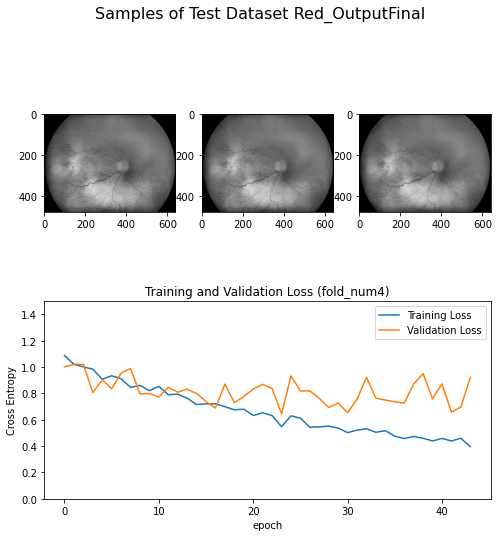

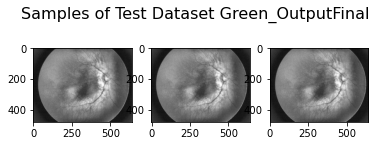

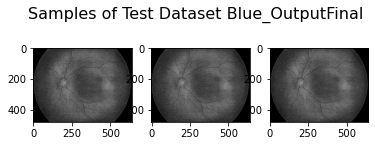

11/11 [==============================] - 12s 601ms/step
Saved 176 correct predictions and 164 incorrect predictions. Valid
Categorical Classification
---------------------
Confusion matrix, without normalization
[[76 25 93]
 [ 5  7  8]
 [23 10 93]]
[[76 25 93]
 [ 5  7  8]
 [23 10 93]]


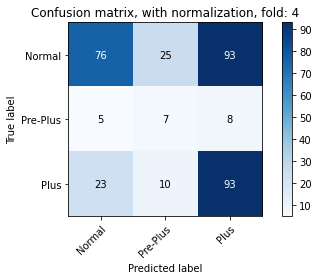

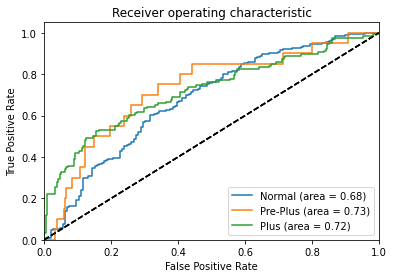

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12425590903829168042
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 48841162752
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
    link {
      device_id: 2
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 1397525987921097197
physical_device_desc: "device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:18:00.0, compute capability: 8.6"
xla_global_id: 416903419
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 48621879296
locality {
  bus_id: 1
  links {
    link {
      type: "StreamExecutor"
      strength: 1
    }
    link {
      device_id: 2
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 11822761081878165481
physical_device_desc: "device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:8a:00.0, compute capability: 8.6"
xla_global_id: 2144165316
, na

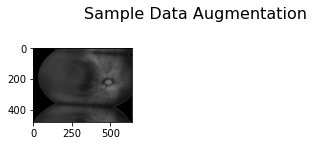

y Labels:  [[0. 0. 1.]]
sample img, max value:  0.5176471
sample img, min value:  0.0


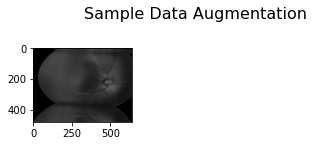

y Labels:  [[0. 0. 1.]]
sample img, max value:  0.5137255
sample img, min value:  0.0


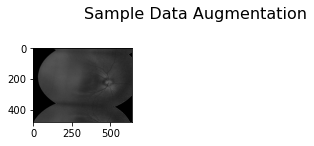

y Labels:  [[0. 0. 1.]]
sample img, max value:  0.5254902
sample img, min value:  0.0


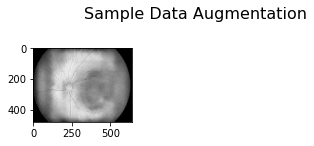

y Labels:  [[0. 0. 1.]]
sample img, max value:  1.0
sample img, min value:  0.0


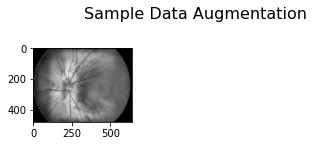

y Labels:  [[0. 0. 1.]]
sample img, max value:  0.95294124
sample img, min value:  0.0


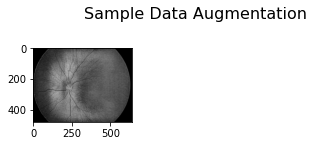

y Labels:  [[0. 0. 1.]]
sample img, max value:  0.78823537
sample img, min value:  0.0
########################## 

KerasTensor(type_spec=TensorSpec(shape=(2,), dtype=tf.int32, name=None), inferred_value=[None, 1280], name='tf.compat.v1.shape_9/Shape:0', description="created by layer 'tf.compat.v1.shape_9'")
# 

KerasTensor(type_spec=TensorSpec(shape=(4,), dtype=tf.int32, name=None), inferred_value=[None, 15, 20, 1280], name='tf.compat.v1.shape_10/Shape:0', description="created by layer 'tf.compat.v1.shape_10'")
# 

KerasTensor(type_spec=TensorSpec(shape=(2,), dtype=tf.int32, name=None), inferred_value=[None, 1280], name='tf.compat.v1.shape_11/Shape:0', description="created by layer 'tf.compat.v1.shape_11'")
Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13123 (InputLayer)       [(None, 480, 640, 9  0           [

 block1a_project_activation3 (A  (None, 240, 320, 24  0          ['block1a_project_bn3[0][0]']    
 ctivation)                     )                                                                 
                                                                                                  
 block1a_add1 (Add)             (None, 240, 320, 24  0           ['block1a_project_activation1[0][
                                )                                0]',                             
                                                                  'stem_activation1[0][0]']       
                                                                                                  
 block1a_add2 (Add)             (None, 240, 320, 24  0           ['block1a_project_activation2[0][
                                )                                0]',                             
                                                                  'stem_activation2[0][0]']       
          

                                                                                                  
 block2a_expand_activation3 (Ac  (None, 120, 160, 96  0          ['block2a_expand_bn3[0][0]']     
 tivation)                      )                                                                 
                                                                                                  
 block2a_project_conv1 (Conv2D)  (None, 120, 160, 48  4608       ['block2a_expand_activation1[0][0
                                )                                ]']                              
                                                                                                  
 block2a_project_conv2 (Conv2D)  (None, 120, 160, 48  4608       ['block2a_expand_activation2[0][0
                                )                                ]']                              
                                                                                                  
 block2a_p

                                )                                 'block2a_project_bn3[0][0]']    
                                                                                                  
 block2c_expand_conv1 (Conv2D)  (None, 120, 160, 19  82944       ['block2b_add1[0][0]']           
                                2)                                                                
                                                                                                  
 block2c_expand_conv2 (Conv2D)  (None, 120, 160, 19  82944       ['block2b_add2[0][0]']           
                                2)                                                                
                                                                                                  
 block2c_expand_conv3 (Conv2D)  (None, 120, 160, 19  82944       ['block2b_add3[0][0]']           
                                2)                                                                
          

 block2d_expand_activation1 (Ac  (None, 120, 160, 19  0          ['block2d_expand_bn1[0][0]']     
 tivation)                      2)                                                                
                                                                                                  
 block2d_expand_activation2 (Ac  (None, 120, 160, 19  0          ['block2d_expand_bn2[0][0]']     
 tivation)                      2)                                                                
                                                                                                  
 block2d_expand_activation3 (Ac  (None, 120, 160, 19  0          ['block2d_expand_bn3[0][0]']     
 tivation)                      2)                                                                
                                                                                                  
 block2d_project_conv1 (Conv2D)  (None, 120, 160, 48  9216       ['block2d_expand_activation1[0][0
          

                                                                                                  
 block3a_project_bn3 (BatchNorm  (None, 60, 80, 64)  256         ['block3a_project_conv3[0][0]']  
 alization)                                                                                       
                                                                                                  
 block3b_expand_conv1 (Conv2D)  (None, 60, 80, 256)  147456      ['block3a_project_bn1[0][0]']    
                                                                                                  
 block3b_expand_conv2 (Conv2D)  (None, 60, 80, 256)  147456      ['block3a_project_bn2[0][0]']    
                                                                                                  
 block3b_expand_conv3 (Conv2D)  (None, 60, 80, 256)  147456      ['block3a_project_bn3[0][0]']    
                                                                                                  
 block3b_e

 tivation)                                                                                        
                                                                                                  
 block3c_project_conv1 (Conv2D)  (None, 60, 80, 64)  16384       ['block3c_expand_activation1[0][0
                                                                 ]']                              
                                                                                                  
 block3c_project_conv2 (Conv2D)  (None, 60, 80, 64)  16384       ['block3c_expand_activation2[0][0
                                                                 ]']                              
                                                                                                  
 block3c_project_conv3 (Conv2D)  (None, 60, 80, 64)  16384       ['block3c_expand_activation3[0][0
                                                                 ]']                              
          

 block3d_add1 (Add)             (None, 60, 80, 64)   0           ['block3d_drop1[0][0]',          
                                                                  'block3c_add1[0][0]']           
                                                                                                  
 block3d_add2 (Add)             (None, 60, 80, 64)   0           ['block3d_drop2[0][0]',          
                                                                  'block3c_add2[0][0]']           
                                                                                                  
 block3d_add3 (Add)             (None, 60, 80, 64)   0           ['block3d_drop3[0][0]',          
                                                                  'block3c_add3[0][0]']           
                                                                                                  
 block4a_expand_conv1 (Conv2D)  (None, 60, 80, 256)  16384       ['block3d_add1[0][0]']           
          

 block4a_se_expand2 (Conv2D)    (None, 1, 1, 256)    4352        ['block4a_se_reduce2[0][0]']     
                                                                                                  
 block4a_se_expand3 (Conv2D)    (None, 1, 1, 256)    4352        ['block4a_se_reduce3[0][0]']     
                                                                                                  
 block4a_se_excite1 (Multiply)  (None, 30, 40, 256)  0           ['block4a_activation1[0][0]',    
                                                                  'block4a_se_expand1[0][0]']     
                                                                                                  
 block4a_se_excite2 (Multiply)  (None, 30, 40, 256)  0           ['block4a_activation2[0][0]',    
                                                                  'block4a_se_expand2[0][0]']     
                                                                                                  
 block4a_s

 ragePooling2D)                                                                                   
                                                                                                  
 block4b_se_squeeze3 (GlobalAve  (None, 512)         0           ['block4b_activation3[0][0]']    
 ragePooling2D)                                                                                   
                                                                                                  
 block4b_se_reshape1 (Reshape)  (None, 1, 1, 512)    0           ['block4b_se_squeeze1[0][0]']    
                                                                                                  
 block4b_se_reshape2 (Reshape)  (None, 1, 1, 512)    0           ['block4b_se_squeeze2[0][0]']    
                                                                                                  
 block4b_se_reshape3 (Reshape)  (None, 1, 1, 512)    0           ['block4b_se_squeeze3[0][0]']    
          

 block4c_expand_activation3 (Ac  (None, 30, 40, 512)  0          ['block4c_expand_bn3[0][0]']     
 tivation)                                                                                        
                                                                                                  
 block4c_dwconv21 (DepthwiseCon  (None, 30, 40, 512)  4608       ['block4c_expand_activation1[0][0
 v2D)                                                            ]']                              
                                                                                                  
 block4c_dwconv22 (DepthwiseCon  (None, 30, 40, 512)  4608       ['block4c_expand_activation2[0][0
 v2D)                                                            ]']                              
                                                                                                  
 block4c_dwconv23 (DepthwiseCon  (None, 30, 40, 512)  4608       ['block4c_expand_activation3[0][0
 v2D)     

 block4c_drop2 (Dropout)        (None, 30, 40, 128)  0           ['block4c_project_bn2[0][0]']    
                                                                                                  
 block4c_drop3 (Dropout)        (None, 30, 40, 128)  0           ['block4c_project_bn3[0][0]']    
                                                                                                  
 block4c_add1 (Add)             (None, 30, 40, 128)  0           ['block4c_drop1[0][0]',          
                                                                  'block4b_add1[0][0]']           
                                                                                                  
 block4c_add2 (Add)             (None, 30, 40, 128)  0           ['block4c_drop2[0][0]',          
                                                                  'block4b_add2[0][0]']           
                                                                                                  
 block4c_a

 block4d_se_reduce3 (Conv2D)    (None, 1, 1, 32)     16416       ['block4d_se_reshape3[0][0]']    
                                                                                                  
 block4d_se_expand1 (Conv2D)    (None, 1, 1, 512)    16896       ['block4d_se_reduce1[0][0]']     
                                                                                                  
 block4d_se_expand2 (Conv2D)    (None, 1, 1, 512)    16896       ['block4d_se_reduce2[0][0]']     
                                                                                                  
 block4d_se_expand3 (Conv2D)    (None, 1, 1, 512)    16896       ['block4d_se_reduce3[0][0]']     
                                                                                                  
 block4d_se_excite1 (Multiply)  (None, 30, 40, 512)  0           ['block4d_activation1[0][0]',    
                                                                  'block4d_se_expand1[0][0]']     
          

 block4e_bn2 (BatchNormalizatio  (None, 30, 40, 512)  2048       ['block4e_dwconv22[0][0]']       
 n)                                                                                               
                                                                                                  
 block4e_bn3 (BatchNormalizatio  (None, 30, 40, 512)  2048       ['block4e_dwconv23[0][0]']       
 n)                                                                                               
                                                                                                  
 block4e_activation1 (Activatio  (None, 30, 40, 512)  0          ['block4e_bn1[0][0]']            
 n)                                                                                               
                                                                                                  
 block4e_activation2 (Activatio  (None, 30, 40, 512)  0          ['block4e_bn2[0][0]']            
 n)       

 block4f_expand_conv2 (Conv2D)  (None, 30, 40, 512)  65536       ['block4e_add2[0][0]']           
                                                                                                  
 block4f_expand_conv3 (Conv2D)  (None, 30, 40, 512)  65536       ['block4e_add3[0][0]']           
                                                                                                  
 block4f_expand_bn1 (BatchNorma  (None, 30, 40, 512)  2048       ['block4f_expand_conv1[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4f_expand_bn2 (BatchNorma  (None, 30, 40, 512)  2048       ['block4f_expand_conv2[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4f_e

                                                                  'block4f_se_expand3[0][0]']     
                                                                                                  
 block4f_project_conv1 (Conv2D)  (None, 30, 40, 128)  65536      ['block4f_se_excite1[0][0]']     
                                                                                                  
 block4f_project_conv2 (Conv2D)  (None, 30, 40, 128)  65536      ['block4f_se_excite2[0][0]']     
                                                                                                  
 block4f_project_conv3 (Conv2D)  (None, 30, 40, 128)  65536      ['block4f_se_excite3[0][0]']     
                                                                                                  
 block4f_project_bn1 (BatchNorm  (None, 30, 40, 128)  512        ['block4f_project_conv1[0][0]']  
 alization)                                                                                       
          

 block5a_se_squeeze1 (GlobalAve  (None, 768)         0           ['block5a_activation1[0][0]']    
 ragePooling2D)                                                                                   
                                                                                                  
 block5a_se_squeeze2 (GlobalAve  (None, 768)         0           ['block5a_activation2[0][0]']    
 ragePooling2D)                                                                                   
                                                                                                  
 block5a_se_squeeze3 (GlobalAve  (None, 768)         0           ['block5a_activation3[0][0]']    
 ragePooling2D)                                                                                   
                                                                                                  
 block5a_se_reshape1 (Reshape)  (None, 1, 1, 768)    0           ['block5a_se_squeeze1[0][0]']    
          

                                                                                                  
 block5b_bn1 (BatchNormalizatio  (None, 30, 40, 960)  3840       ['block5b_dwconv21[0][0]']       
 n)                                                                                               
                                                                                                  
 block5b_bn2 (BatchNormalizatio  (None, 30, 40, 960)  3840       ['block5b_dwconv22[0][0]']       
 n)                                                                                               
                                                                                                  
 block5b_bn3 (BatchNormalizatio  (None, 30, 40, 960)  3840       ['block5b_dwconv23[0][0]']       
 n)                                                                                               
                                                                                                  
 block5b_a

                                                                  'block5a_project_bn3[0][0]']    
                                                                                                  
 block5c_expand_conv1 (Conv2D)  (None, 30, 40, 960)  153600      ['block5b_add1[0][0]']           
                                                                                                  
 block5c_expand_conv2 (Conv2D)  (None, 30, 40, 960)  153600      ['block5b_add2[0][0]']           
                                                                                                  
 block5c_expand_conv3 (Conv2D)  (None, 30, 40, 960)  153600      ['block5b_add3[0][0]']           
                                                                                                  
 block5c_expand_bn1 (BatchNorma  (None, 30, 40, 960)  3840       ['block5c_expand_conv1[0][0]']   
 lization)                                                                                        
          

 block5c_se_excite2 (Multiply)  (None, 30, 40, 960)  0           ['block5c_activation2[0][0]',    
                                                                  'block5c_se_expand2[0][0]']     
                                                                                                  
 block5c_se_excite3 (Multiply)  (None, 30, 40, 960)  0           ['block5c_activation3[0][0]',    
                                                                  'block5c_se_expand3[0][0]']     
                                                                                                  
 block5c_project_conv1 (Conv2D)  (None, 30, 40, 160)  153600     ['block5c_se_excite1[0][0]']     
                                                                                                  
 block5c_project_conv2 (Conv2D)  (None, 30, 40, 160)  153600     ['block5c_se_excite2[0][0]']     
                                                                                                  
 block5c_p

                                                                                                  
 block5d_activation3 (Activatio  (None, 30, 40, 960)  0          ['block5d_bn3[0][0]']            
 n)                                                                                               
                                                                                                  
 block5d_se_squeeze1 (GlobalAve  (None, 960)         0           ['block5d_activation1[0][0]']    
 ragePooling2D)                                                                                   
                                                                                                  
 block5d_se_squeeze2 (GlobalAve  (None, 960)         0           ['block5d_activation2[0][0]']    
 ragePooling2D)                                                                                   
                                                                                                  
 block5d_s

 lization)                                                                                        
                                                                                                  
 block5e_expand_activation1 (Ac  (None, 30, 40, 960)  0          ['block5e_expand_bn1[0][0]']     
 tivation)                                                                                        
                                                                                                  
 block5e_expand_activation2 (Ac  (None, 30, 40, 960)  0          ['block5e_expand_bn2[0][0]']     
 tivation)                                                                                        
                                                                                                  
 block5e_expand_activation3 (Ac  (None, 30, 40, 960)  0          ['block5e_expand_bn3[0][0]']     
 tivation)                                                                                        
          

 block5e_project_bn2 (BatchNorm  (None, 30, 40, 160)  640        ['block5e_project_conv2[0][0]']  
 alization)                                                                                       
                                                                                                  
 block5e_project_bn3 (BatchNorm  (None, 30, 40, 160)  640        ['block5e_project_conv3[0][0]']  
 alization)                                                                                       
                                                                                                  
 block5e_drop1 (Dropout)        (None, 30, 40, 160)  0           ['block5e_project_bn1[0][0]']    
                                                                                                  
 block5e_drop2 (Dropout)        (None, 30, 40, 160)  0           ['block5e_project_bn2[0][0]']    
                                                                                                  
 block5e_d

 block5f_se_reshape2 (Reshape)  (None, 1, 1, 960)    0           ['block5f_se_squeeze2[0][0]']    
                                                                                                  
 block5f_se_reshape3 (Reshape)  (None, 1, 1, 960)    0           ['block5f_se_squeeze3[0][0]']    
                                                                                                  
 block5f_se_reduce1 (Conv2D)    (None, 1, 1, 40)     38440       ['block5f_se_reshape1[0][0]']    
                                                                                                  
 block5f_se_reduce2 (Conv2D)    (None, 1, 1, 40)     38440       ['block5f_se_reshape2[0][0]']    
                                                                                                  
 block5f_se_reduce3 (Conv2D)    (None, 1, 1, 40)     38440       ['block5f_se_reshape3[0][0]']    
                                                                                                  
 block5f_s

 v2D)                                                            ]']                              
                                                                                                  
 block5g_dwconv23 (DepthwiseCon  (None, 30, 40, 960)  8640       ['block5g_expand_activation3[0][0
 v2D)                                                            ]']                              
                                                                                                  
 block5g_bn1 (BatchNormalizatio  (None, 30, 40, 960)  3840       ['block5g_dwconv21[0][0]']       
 n)                                                                                               
                                                                                                  
 block5g_bn2 (BatchNormalizatio  (None, 30, 40, 960)  3840       ['block5g_dwconv22[0][0]']       
 n)                                                                                               
          

 block5g_add2 (Add)             (None, 30, 40, 160)  0           ['block5g_drop2[0][0]',          
                                                                  'block5f_add2[0][0]']           
                                                                                                  
 block5g_add3 (Add)             (None, 30, 40, 160)  0           ['block5g_drop3[0][0]',          
                                                                  'block5f_add3[0][0]']           
                                                                                                  
 block5h_expand_conv1 (Conv2D)  (None, 30, 40, 960)  153600      ['block5g_add1[0][0]']           
                                                                                                  
 block5h_expand_conv2 (Conv2D)  (None, 30, 40, 960)  153600      ['block5g_add2[0][0]']           
                                                                                                  
 block5h_e

                                                                                                  
 block5h_se_excite1 (Multiply)  (None, 30, 40, 960)  0           ['block5h_activation1[0][0]',    
                                                                  'block5h_se_expand1[0][0]']     
                                                                                                  
 block5h_se_excite2 (Multiply)  (None, 30, 40, 960)  0           ['block5h_activation2[0][0]',    
                                                                  'block5h_se_expand2[0][0]']     
                                                                                                  
 block5h_se_excite3 (Multiply)  (None, 30, 40, 960)  0           ['block5h_activation3[0][0]',    
                                                                  'block5h_se_expand3[0][0]']     
                                                                                                  
 block5h_p

 n)                                                                                               
                                                                                                  
 block5i_activation2 (Activatio  (None, 30, 40, 960)  0          ['block5i_bn2[0][0]']            
 n)                                                                                               
                                                                                                  
 block5i_activation3 (Activatio  (None, 30, 40, 960)  0          ['block5i_bn3[0][0]']            
 n)                                                                                               
                                                                                                  
 block5i_se_squeeze1 (GlobalAve  (None, 960)         0           ['block5i_activation1[0][0]']    
 ragePooling2D)                                                                                   
          

 block6a_expand_bn2 (BatchNorma  (None, 30, 40, 960)  3840       ['block6a_expand_conv2[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6a_expand_bn3 (BatchNorma  (None, 30, 40, 960)  3840       ['block6a_expand_conv3[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6a_expand_activation1 (Ac  (None, 30, 40, 960)  0          ['block6a_expand_bn1[0][0]']     
 tivation)                                                                                        
                                                                                                  
 block6a_expand_activation2 (Ac  (None, 30, 40, 960)  0          ['block6a_expand_bn2[0][0]']     
 tivation)

                                                                                                  
 block6a_project_bn1 (BatchNorm  (None, 15, 20, 256)  1024       ['block6a_project_conv1[0][0]']  
 alization)                                                                                       
                                                                                                  
 block6a_project_bn2 (BatchNorm  (None, 15, 20, 256)  1024       ['block6a_project_conv2[0][0]']  
 alization)                                                                                       
                                                                                                  
 block6a_project_bn3 (BatchNorm  (None, 15, 20, 256)  1024       ['block6a_project_conv3[0][0]']  
 alization)                                                                                       
                                                                                                  
 block6b_e

 block6b_se_reduce3 (Conv2D)    (None, 1, 1, 64)     98368       ['block6b_se_reshape3[0][0]']    
                                                                                                  
 block6b_se_expand1 (Conv2D)    (None, 1, 1, 1536)   99840       ['block6b_se_reduce1[0][0]']     
                                                                                                  
 block6b_se_expand2 (Conv2D)    (None, 1, 1, 1536)   99840       ['block6b_se_reduce2[0][0]']     
                                                                                                  
 block6b_se_expand3 (Conv2D)    (None, 1, 1, 1536)   99840       ['block6b_se_reduce3[0][0]']     
                                                                                                  
 block6b_se_excite1 (Multiply)  (None, 15, 20, 1536  0           ['block6b_activation1[0][0]',    
                                )                                 'block6b_se_expand1[0][0]']     
          

 block6c_bn1 (BatchNormalizatio  (None, 15, 20, 1536  6144       ['block6c_dwconv21[0][0]']       
 n)                             )                                                                 
                                                                                                  
 block6c_bn2 (BatchNormalizatio  (None, 15, 20, 1536  6144       ['block6c_dwconv22[0][0]']       
 n)                             )                                                                 
                                                                                                  
 block6c_bn3 (BatchNormalizatio  (None, 15, 20, 1536  6144       ['block6c_dwconv23[0][0]']       
 n)                             )                                                                 
                                                                                                  
 block6c_activation1 (Activatio  (None, 15, 20, 1536  0          ['block6c_bn1[0][0]']            
 n)       

                                                                                                  
 block6d_expand_conv1 (Conv2D)  (None, 15, 20, 1536  393216      ['block6c_add1[0][0]']           
                                )                                                                 
                                                                                                  
 block6d_expand_conv2 (Conv2D)  (None, 15, 20, 1536  393216      ['block6c_add2[0][0]']           
                                )                                                                 
                                                                                                  
 block6d_expand_conv3 (Conv2D)  (None, 15, 20, 1536  393216      ['block6c_add3[0][0]']           
                                )                                                                 
                                                                                                  
 block6d_e

                                )                                 'block6d_se_expand1[0][0]']     
                                                                                                  
 block6d_se_excite2 (Multiply)  (None, 15, 20, 1536  0           ['block6d_activation2[0][0]',    
                                )                                 'block6d_se_expand2[0][0]']     
                                                                                                  
 block6d_se_excite3 (Multiply)  (None, 15, 20, 1536  0           ['block6d_activation3[0][0]',    
                                )                                 'block6d_se_expand3[0][0]']     
                                                                                                  
 block6d_project_conv1 (Conv2D)  (None, 15, 20, 256)  393216     ['block6d_se_excite1[0][0]']     
                                                                                                  
 block6d_p

 block6e_activation1 (Activatio  (None, 15, 20, 1536  0          ['block6e_bn1[0][0]']            
 n)                             )                                                                 
                                                                                                  
 block6e_activation2 (Activatio  (None, 15, 20, 1536  0          ['block6e_bn2[0][0]']            
 n)                             )                                                                 
                                                                                                  
 block6e_activation3 (Activatio  (None, 15, 20, 1536  0          ['block6e_bn3[0][0]']            
 n)                             )                                                                 
                                                                                                  
 block6e_se_squeeze1 (GlobalAve  (None, 1536)        0           ['block6e_activation1[0][0]']    
 ragePooli

                                                                                                  
 block6f_expand_bn1 (BatchNorma  (None, 15, 20, 1536  6144       ['block6f_expand_conv1[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 block6f_expand_bn2 (BatchNorma  (None, 15, 20, 1536  6144       ['block6f_expand_conv2[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 block6f_expand_bn3 (BatchNorma  (None, 15, 20, 1536  6144       ['block6f_expand_conv3[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 block6f_e

                                                                                                  
 block6f_project_conv2 (Conv2D)  (None, 15, 20, 256)  393216     ['block6f_se_excite2[0][0]']     
                                                                                                  
 block6f_project_conv3 (Conv2D)  (None, 15, 20, 256)  393216     ['block6f_se_excite3[0][0]']     
                                                                                                  
 block6f_project_bn1 (BatchNorm  (None, 15, 20, 256)  1024       ['block6f_project_conv1[0][0]']  
 alization)                                                                                       
                                                                                                  
 block6f_project_bn2 (BatchNorm  (None, 15, 20, 256)  1024       ['block6f_project_conv2[0][0]']  
 alization)                                                                                       
          

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



680/680 [==============================] - 411s 371ms/step - loss: 1.0806 - tp: 32.0000 - accuracy: 0.4125 - val_loss: 1.1771 - val_tp: 8.0000 - val_accuracy: 0.2353
Epoch 2/90
680/680 [==============================] - 251s 369ms/step - loss: 1.0138 - tp: 280.0000 - accuracy: 0.5154 - val_loss: 1.1367 - val_tp: 48.0000 - val_accuracy: 0.3853
Epoch 3/90
680/680 [==============================] - 252s 371ms/step - loss: 0.9744 - tp: 386.0000 - accuracy: 0.5184 - val_loss: 1.0675 - val_tp: 75.0000 - val_accuracy: 0.4324
Epoch 4/90
680/680 [==============================] - 257s 378ms/step - loss: 0.9404 - tp: 444.0000 - accuracy: 0.5213 - val_loss: 0.9732 - val_tp: 101.0000 - val_accuracy: 0.4441
Epoch 5/90
680/680 [==============================] - 256s 376ms/step - loss: 0.8745 - tp: 520.0000 - accuracy: 0.5559 - val_loss: 0.9678 - val_tp: 133.0000 - val_accuracy: 0.5294
Epoch 6/90
680/680 [==============================] - 255s 374ms/step - loss: 0.8990 - tp: 575.0000 - accuracy: 0.58

680/680 [==============================] - 249s 367ms/step - loss: 0.4029 - tp: 1057.0000 - accuracy: 0.7882 - val_loss: 0.7896 - val_tp: 235.0000 - val_accuracy: 0.7029
Epoch 47/90
680/680 [==============================] - 254s 373ms/step - loss: 0.3945 - tp: 1051.0000 - accuracy: 0.7897 - val_loss: 0.8201 - val_tp: 239.0000 - val_accuracy: 0.7029
Epoch 48/90
680/680 [==============================] - 254s 374ms/step - loss: 0.4076 - tp: 1069.0000 - accuracy: 0.8000 - val_loss: 0.7575 - val_tp: 245.0000 - val_accuracy: 0.7235
Epoch 49/90
680/680 [==============================] - 254s 373ms/step - loss: 0.4037 - tp: 1061.0000 - accuracy: 0.7949 - val_loss: 0.8836 - val_tp: 231.0000 - val_accuracy: 0.6794
Epoch 50/90
680/680 [==============================] - 258s 379ms/step - loss: 0.4025 - tp: 1067.0000 - accuracy: 0.8015 - val_loss: 0.8678 - val_tp: 232.0000 - val_accuracy: 0.6912
Epoch 51/90
680/680 [==============================] - 255s 375ms/step - loss: 0.3638 - tp: 1086.0000 

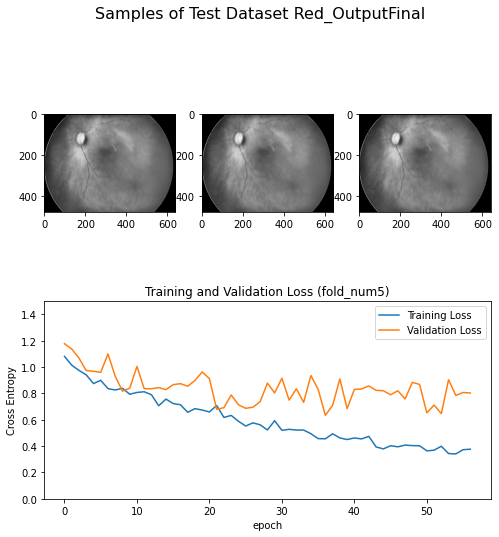

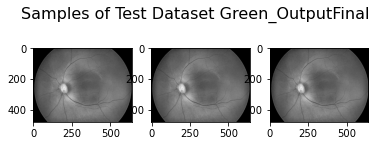

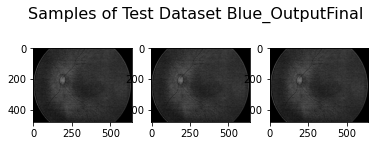

11/11 [==============================] - 12s 612ms/step
Saved 178 correct predictions and 162 incorrect predictions. Valid
Categorical Classification
---------------------
Confusion matrix, without normalization
[[117  13  64]
 [ 10   3   7]
 [ 59   9  58]]
[[117  13  64]
 [ 10   3   7]
 [ 59   9  58]]


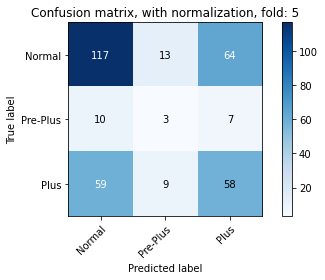

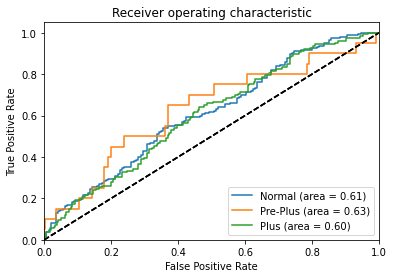

In [3]:

# FoldList = [1,2,3,4,5]

layersList = ['Red_OutputFinal','Green_OutputFinal', 'Blue_OutputFinal']
FoldList = [2,3,4,5]

# FoldList.reverse()

for foldVariable in FoldList:
    All5Fold(layersList[0],layersList[1],layersList[2],foldVariable)


